### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from tensorflow import keras

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### Defining functions

In [42]:
def plot_dists(df: pd.DataFrame):
  n_columns = len(df.columns)

  n_cols = min(3, n_columns)
  n_rows = n_columns // 3 + 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

  for i in range(n_rows):
      for j in range(n_cols):
          idx = i * n_cols + j
          if idx < n_columns:
            sns.histplot(df.iloc[:, idx], kde=True, ax=(axs[i, j] if n_rows > 1 else axs[j]))
          else:
            (axs[i, j] if n_rows > 1 else axs[j]).remove()

  plt.tight_layout()
  plt.show()


def plot_scatters(df: pd.DataFrame):
  n_columns = len(df.columns)

  n_cols = min(3, n_columns)
  n_rows = n_columns // 3 + 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

  for i in range(n_rows):
      for j in range(n_cols):
          idx = i * n_cols + j
          if idx < n_columns:
              axs[i, j].scatter(range(len(df.iloc[:, idx])), df.iloc[:, idx])
              axs[i, j].set_title(df.columns[idx])
          else:
              (axs[i, j] if n_rows > 1 else axs[j]).remove()

  plt.tight_layout()
  plt.show()


def plot_lines(df: pd.DataFrame):
  n_columns = len(df.columns)

  n_cols = min(3, n_columns)
  n_rows = n_columns // 3 + 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

  for i in range(n_rows):
      for j in range(n_cols):
          idx = i * n_cols + j
          if idx < n_columns:
              axs[i, j].plot(range(len(df.iloc[:, idx])), df.iloc[:, idx])
              axs[i, j].set_title(df.columns[idx])
          else:
              (axs[i, j] if n_rows > 1 else axs[j]).remove()

  plt.tight_layout()
  plt.show()


def plot_boxes(df: pd.DataFrame):
  n_columns = len(df.columns)

  n_cols = min(3, n_columns)
  n_rows = n_columns // 3 + 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

  for i in range(n_rows):
      for j in range(n_cols):
          idx = i * n_cols + j
          if idx < n_columns:
              axs[i, j].boxplot(df.iloc[:, idx])
              axs[i, j].set_title(df.columns[idx])
          else:
              (axs[i, j] if n_rows > 1 else axs[j]).remove()

  plt.tight_layout()
  plt.show()


def show_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
  mean, std = df[column].mean(), df[column].std()
  low, high = mean - (3 * std), mean + (3 * std)
  outliers = df[(df[column] < low) | (df[column] > high)]
  print('Number of outliers: ', len(outliers), end='\n\n')
  return outliers.head(10)


def sum_difference(series1: pd.Series, series2: pd.Series) -> float:
  return round(sum(abs(series1 - series2)), 2)


def replace_outliers(series: pd.Series) -> pd.Series:
  median = series.median()
  mean, std = series.mean(), series.std()
  outliers = (series <  mean - (3 * std)) | (series > mean + (3 * std))
  series[outliers] = median
  return series


def feature_importance(X: pd.DataFrame, y: pd.Series):
  importance = LinearRegression().fit(X, y).coef_

  for feature, score in zip(X.columns, importance):
    print(f'Feature: {feature}, Score: {round(score, 2)}')

  plt.figure(figsize=(20, 8))
  plt.bar([feature for feature in X.columns], importance)
  plt.show()


def plot_regs(df: pd.DataFrame):
  n_columns = len(df.columns) - 1

  n_cols = min(3, n_columns)
  n_rows = n_columns // 3 + 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5 * n_rows))

  for i in range(n_rows):
      for j in range(n_cols):
          idx = i * n_cols + j
          if idx < n_columns:
            sns.regplot(x=df.columns[idx], y='TargetPrice', color='gold', data=df, ax=(axs[i, j] if n_rows > 1 else axs[j]))
          else:
              (axs[i, j] if n_rows > 1 else axs[j]).remove()

  plt.tight_layout()
  plt.show()


def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy(deep=True)

  for column in df.columns[1:]:
    df[column] = np.log1p(np.abs(df[column]))
  
  df.fillna(0, inplace=True)
    
  return df


def split_dataset(dataset: pd.DataFrame, train_split=0.8) -> tuple:
  count_unqiue_dates = dataset['Date'].nunique()
  unique_dates = dataset['Date'].unique()

  border_date = unique_dates[int(count_unqiue_dates * train_split)]

  train = dataset[dataset['Date'] <= border_date]
  test = dataset[dataset['Date'] > border_date]

  X_train, y_train = train.iloc[:, 1:-1:], train.iloc[:, -1]
  X_test, y_test = test.iloc[:, 1:-1:], test.iloc[:, -1]

  return X_train, X_test, y_train, y_test


def fit_ml_model(ml_model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, scaled=False) -> tuple:
  if scaled:
    X_scaler, y_scaler = StandardScaler(), StandardScaler()

    y_train_reshaped, y_test_reshaped = y_train.to_numpy().reshape(-1, 1), y_test.to_numpy().reshape(-1, 1)

    X_train, y_train = X_scaler.fit_transform(X_train), y_scaler.fit_transform(y_train_reshaped)
    X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test_reshaped)


  ml_model = ml_model.fit(X_train, y_train)

  train_score = ml_model.score(X_train, y_train)
  test_score = ml_model.score(X_test, y_test)

  y_pred = ml_model.predict(X_test)
  
  if scaled:
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = y_scaler.inverse_transform(y_test)

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  
  return train_score, test_score, mse, rmse, mae


def fit_nn_model(nn_model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series, scaled=False) -> tuple:
  if scaled:
    X_scaler, y_scaler = StandardScaler(), StandardScaler()

    y_train_reshaped, y_test_reshaped = y_train.to_numpy().reshape(-1, 1), y_test.to_numpy().reshape(-1, 1)

    X_train, y_train = X_scaler.fit_transform(X_train), y_scaler.fit_transform(y_train_reshaped)
    X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test_reshaped)


  nn_model = nn_model(X_train)
    
  history = nn_model.fit(X_train,
                         y_train,
                         validation_split=0.2,
                         batch_size=64,
                         epochs=10, # The number of epochs has been reduced from 100 in order to save time.
                         verbose=0)

  y_pred = nn_model.predict(X_test, verbose=0)

  train_score = r2_score(y_train, nn_model.predict(X_train, verbose=0))
  test_score = r2_score(y_test, y_pred)

  if scaled:
    y_pred = y_scaler.inverse_transform(y_pred)
    y_test = y_scaler.inverse_transform(y_test)


  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  return train_score, test_score, mse, rmse, mae


def dense_nn_model(X_train=None):
  input = keras.Input((X_train.shape[1]))

  x = keras.layers.Dense(64, activation='relu')(input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  output = keras.layers.Dense(1)(x)

  nn_model = keras.Model(input, output)

  nn_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])

  return nn_model


def lstm_nn_model(X_train=None):
  input = keras.Input((X_train.shape[1], 1))

  x = keras.layers.LSTM(64, return_sequences=True)(input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.LSTM(32, return_sequences=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.LSTM(16, return_sequences=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.LSTM(8)(x)
  x = keras.layers.Dropout(0.2)(x)
  output = keras.layers.Dense(1)(x)

  nn_model = keras.Model(input, output)

  nn_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])
  return nn_model


def gru_nn_model(X_train=None):
  input = keras.Input((X_train.shape[1], 1))

  x = keras.layers.GRU(50, return_sequences=True)(input)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.GRU(50, return_sequences=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.GRU(50, return_sequences=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.GRU(50)(x)
  x = keras.layers.Dropout(0.2)(x)
  output = keras.layers.Dense(1)(x)

  nn_model = keras.Model(input, output)

  nn_model.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.MeanAbsoluteError()])
  return nn_model

### Reading Data.csv and Test.csv files

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Others/Data.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Others/Test.csv')

# Exploratory Data Analysis

Let's check what the data looks like.

On the face of it, we can say that the values in the columns Bid_Price, Ask_Price, FeaturePrice1, FeaturePrice2, FeaturePrice3, FeaturePrice4 are very close to the values in the TargetPrice column, which we need to learn how to predict. Perhaps they have a high linear relation.

In [7]:
data.head(10)

,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
0,2016-04-14,111.58,35,111.59,300,111.59,111.62,111.63,112.04,263236,22556,111.64
1,2016-04-14,5.10,100,5.25,100,5.11,5.11,5.11,5.09,2895,-94,5.10
2,2016-04-14,12.80,500,138.80,100,13.73,13.41,13.41,13.88,3403,-6597,13.51
3,2016-04-14,58.38,250,59.10,3600,59.10,59.19,59.20,59.80,13935,16246,59.23
4,2016-04-14,43.88,500,43.99,500,44.00,44.03,44.03,43.92,185,2215,44.03
5,2016-04-14,0.53,100,0.74,200,0.74,0.74,0.74,0.73,2429,71,0.74
6,2016-04-14,21.18,5000,21.25,400,21.25,21.34,21.37,21.31,136066,92332,21.31
7,2016-04-14,2.78,340,2.79,400,2.78,2.72,2.72,2.80,146493,-263308,2.77
8,2016-04-14,1.48,100,1.75,100,1.75,1.75,1.75,1.74,8050,543,1.75
9,2016-04-14,616.02,8,616.50,1700,616.50,616.61,616.61,614.82,25309,1443,616.50


Almost all features have a high standard deviation.

A high standard deviation suggests that the data points are more widely dispersed, and may be more difficult to predict or generalize from.

In [8]:
data.describe().round(1)

,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
count,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0,18651.0
mean,49.8,7483.4,2769.9,2715.7,109.9,109.8,135.9,51.3,27738.1,-2133.1,50.6
std,118.9,112952.1,22194.9,16258.7,3356.3,3356.3,3940.8,143.4,106210.2,63113.4,118.9
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2398686.0,0.0
25%,5.0,100.0,6.2,100.0,5.7,5.7,4.7,5.7,830.5,-3622.5,5.7
50%,20.5,200.0,23.5,200.0,21.6,21.6,20.7,21.7,5001.0,4.0,21.6
75%,50.4,938.0,54.6,900.0,51.3,51.4,51.4,51.0,18502.5,2367.0,51.0
max,1437.0,3623700.0,200000.0,633852.0,200000.0,200000.0,200000.0,10855.7,5576209.0,1963809.0,1435.0


No missing values.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18651 entries, 0 to 18650
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            18651 non-null  object 
 1   Bid_Price       18651 non-null  float64
 2   Bid_Shares      18651 non-null  int64  
 3   Ask_Price       18651 non-null  float64
 4   Ask_Shares      18651 non-null  int64  
 5   FeaturePrice1   18651 non-null  float64
 6   FeaturePrice2   18651 non-null  float64
 7   FeaturePrice3   18651 non-null  float64
 8   FeaturePrice4   18651 non-null  float64
 9   FeatureShares1  18651 non-null  int64  
 10  FeatureShares2  18651 non-null  int64  
 11  TargetPrice     18651 non-null  float64
dtypes: float64(7), int64(4), object(1)
memory usage: 1.7+ MB


For each date we have a different number of rows.

In [10]:
data['Date'].value_counts()

2016-06-24    370
2016-06-27    225
2016-06-20    221
2016-06-29    219
2016-07-15    219
             ... 
2016-06-22    133
2016-05-18    133
2016-05-27    125
2016-06-21    120
2016-05-12    107
Name: Date, Length: 107, dtype: int64

There are 107 unique dates.

In [11]:
data['Date'].nunique()

107

We can see from the correlation heatmap that the Bid_Price and FeaturePrice4 have a high positive linear correlation with TargetPrice. But the assumption that was made earlier regarding Ask_Price, FeaturePrice1, FeaturePrice2, FeaturePrice3 features is not confirming from this visualization. Most likely, there are many outliers in these features.

A high correlation coefficient indicates a strong positive correlation between two variables, meaning that as one variable increases, the other variable also increases. Conversely, a strong negative correlation means that as one variable increases, the other variable decreases.

It's important to note that correlation does not necessarily imply causation. Just because two variables are strongly correlated does not necessarily mean that one causes the other. There may be other factors that are influencing the relationship between the two variables.

<AxesSubplot:>

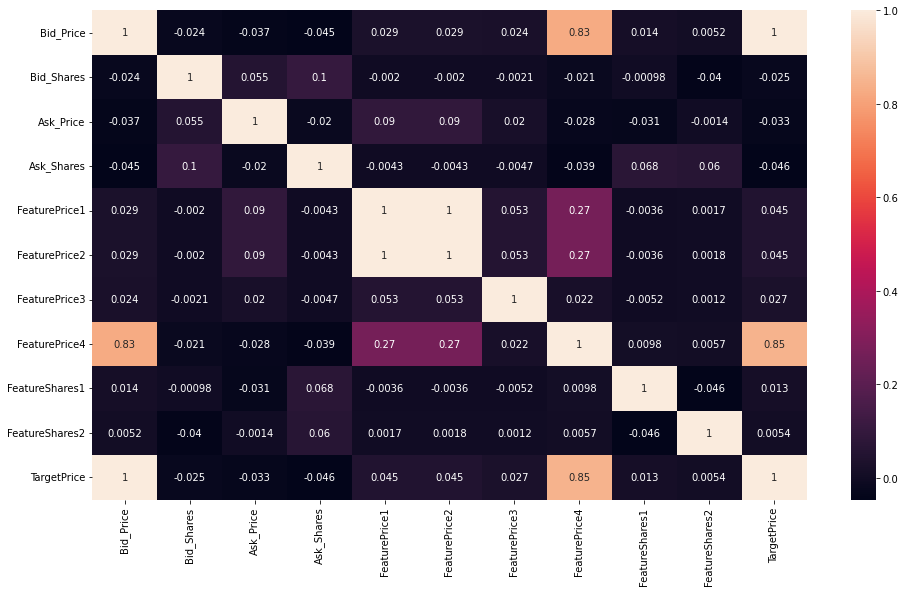

In [12]:
plt.figure(figsize=(16, 9))
sns.heatmap(data.corr(), annot=True)

From the visualization below, we can see that the Bid_Price and TargetPrice features really have a very high linear relation. This is also noticeable in the dependency graph between FeaturePrice4 and TargetPrice, but as you can see, due to outliers, the linearity is distorted. The same can be said about other features: Ask_Price, FeaturePrice1, FeaturePrice2, FeaturePrice3.

In [13]:
px.scatter_matrix(data_frame=data.iloc[:, 1:], dimensions=data.iloc[:, 1:].columns, width=1600, height=1600)

In the following visualization, we can see the distributions for each feature. Almost all have a skewed distribution.

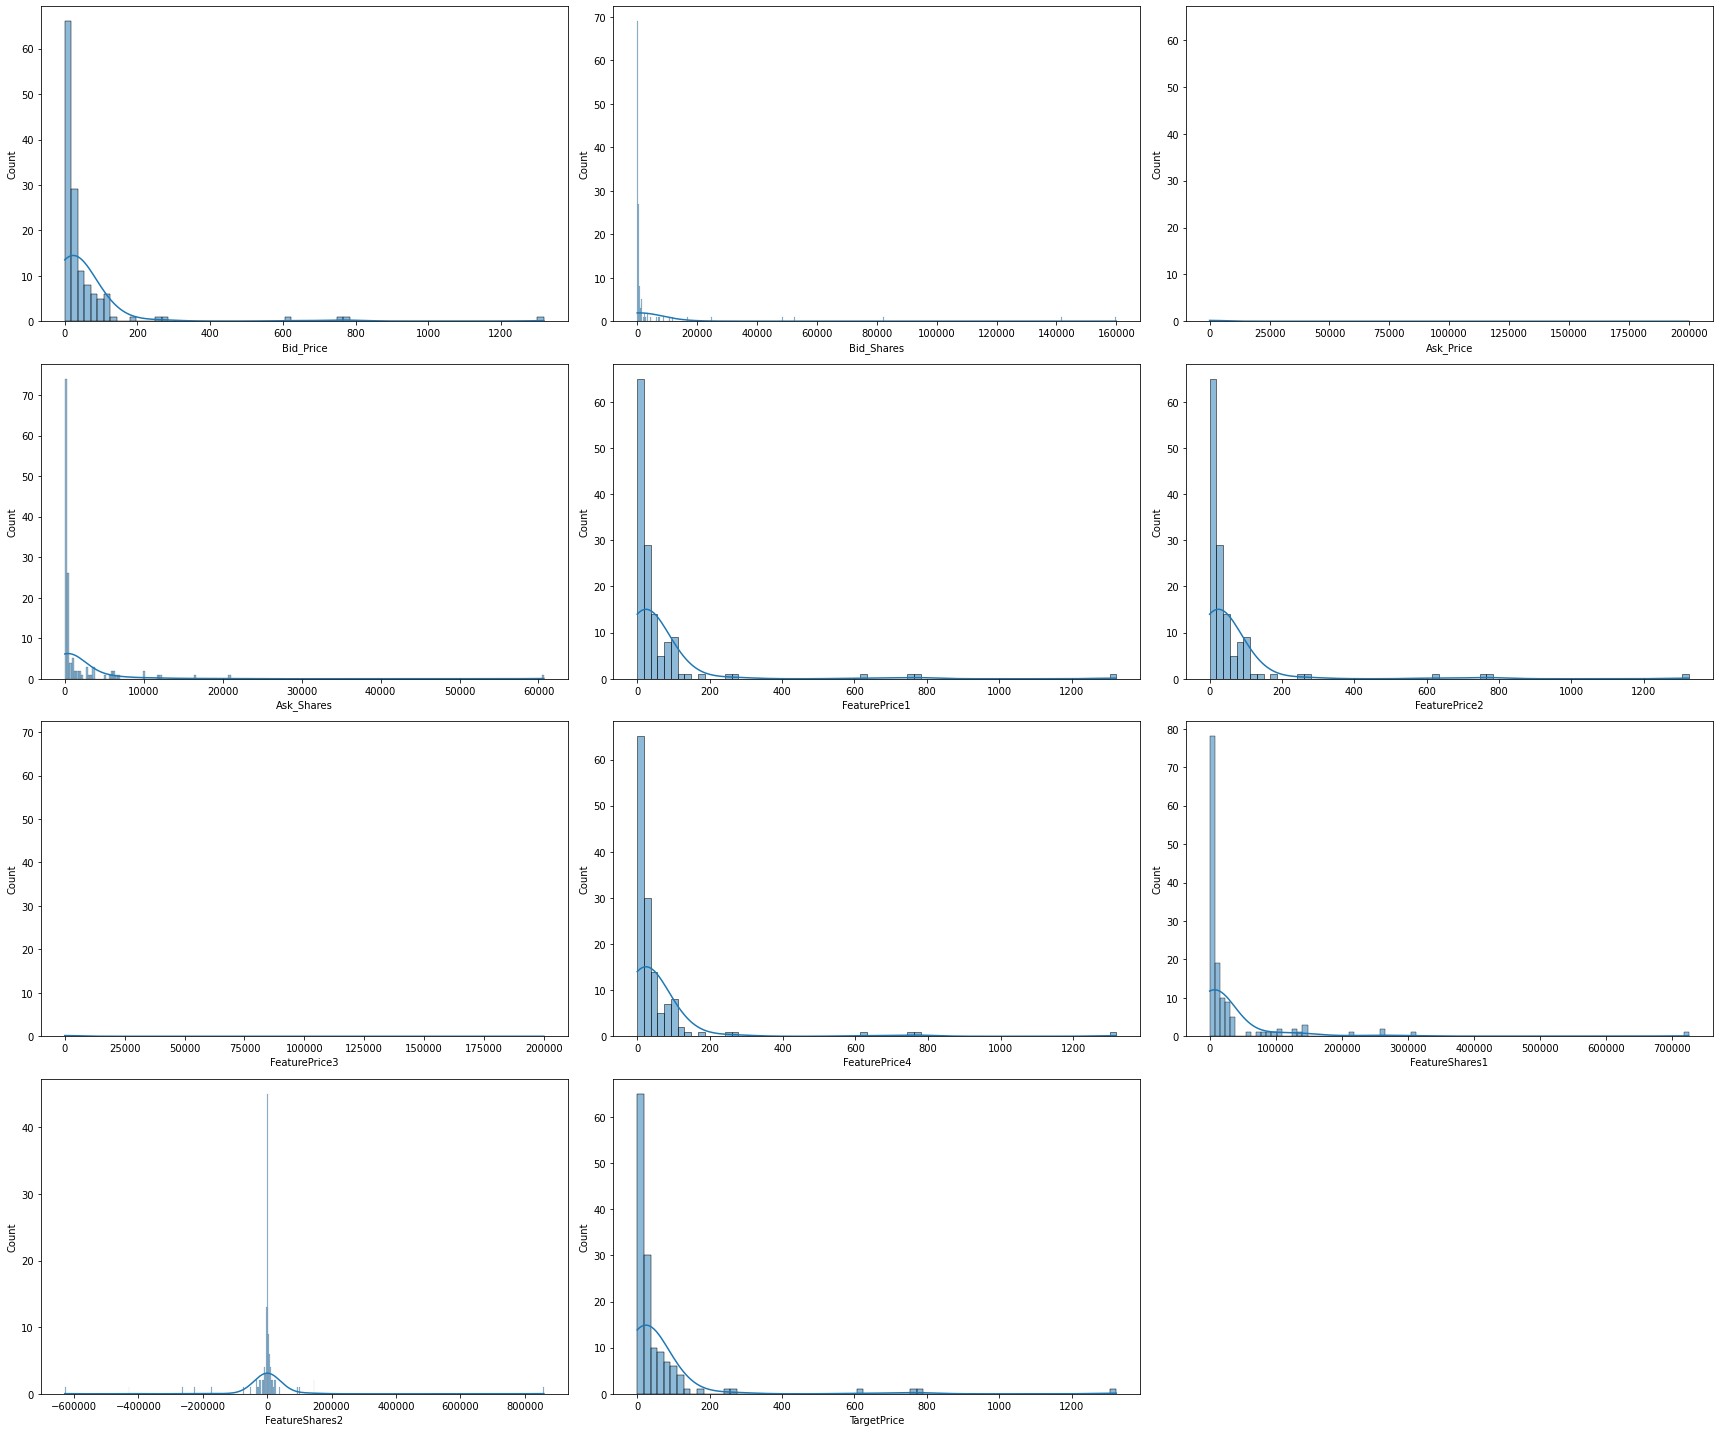

In [14]:
plot_dists(data[data['Date'] == '2016-04-14'].iloc[:, 1:])

From the scatter plots below, we can see the distribution of data by row, it clearly shows us the outliers.

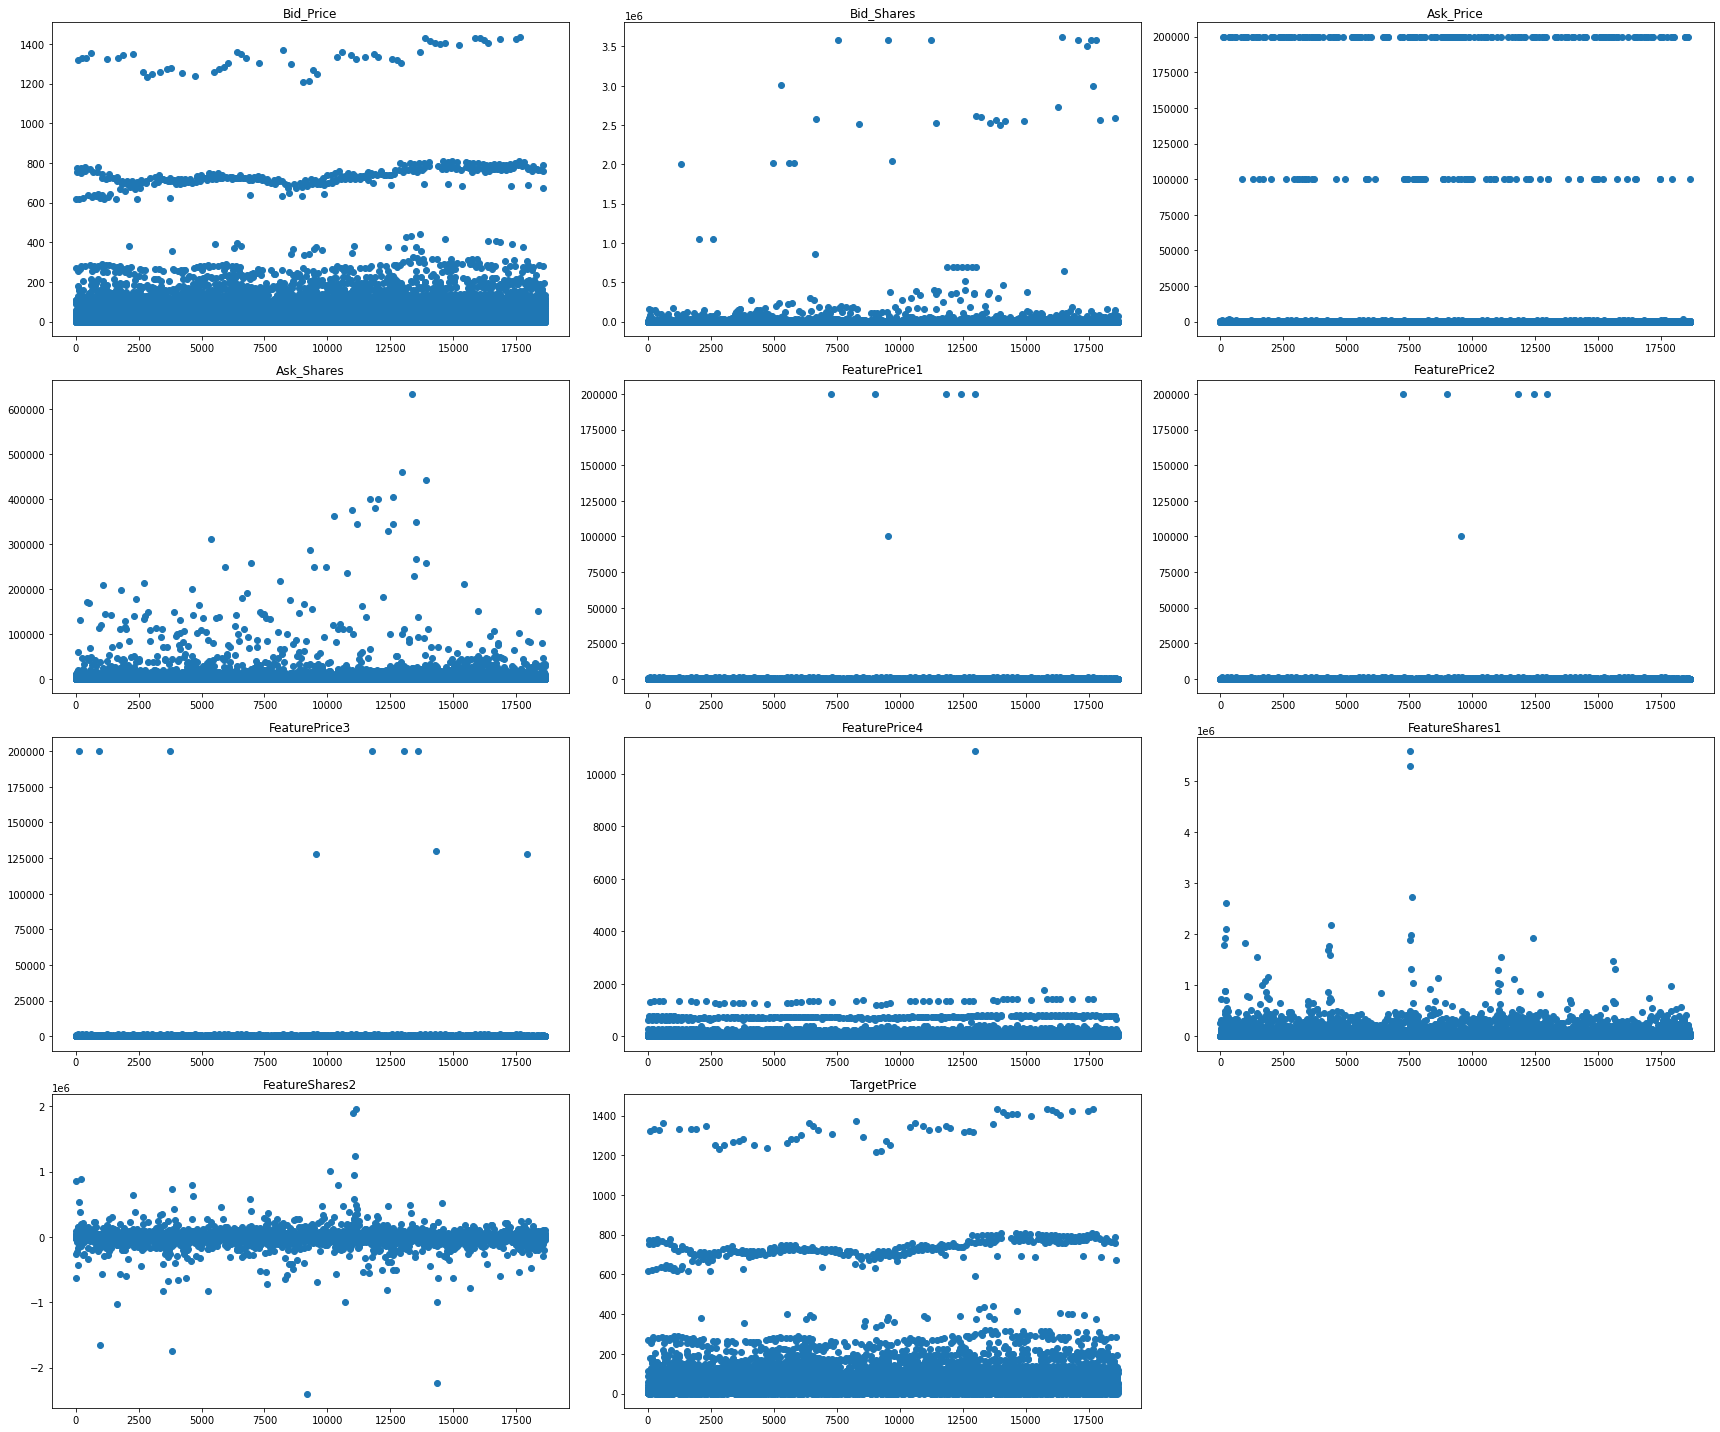

In [15]:
plot_scatters(data.iloc[:, 1:])

The same can be seen in the following visualizations.

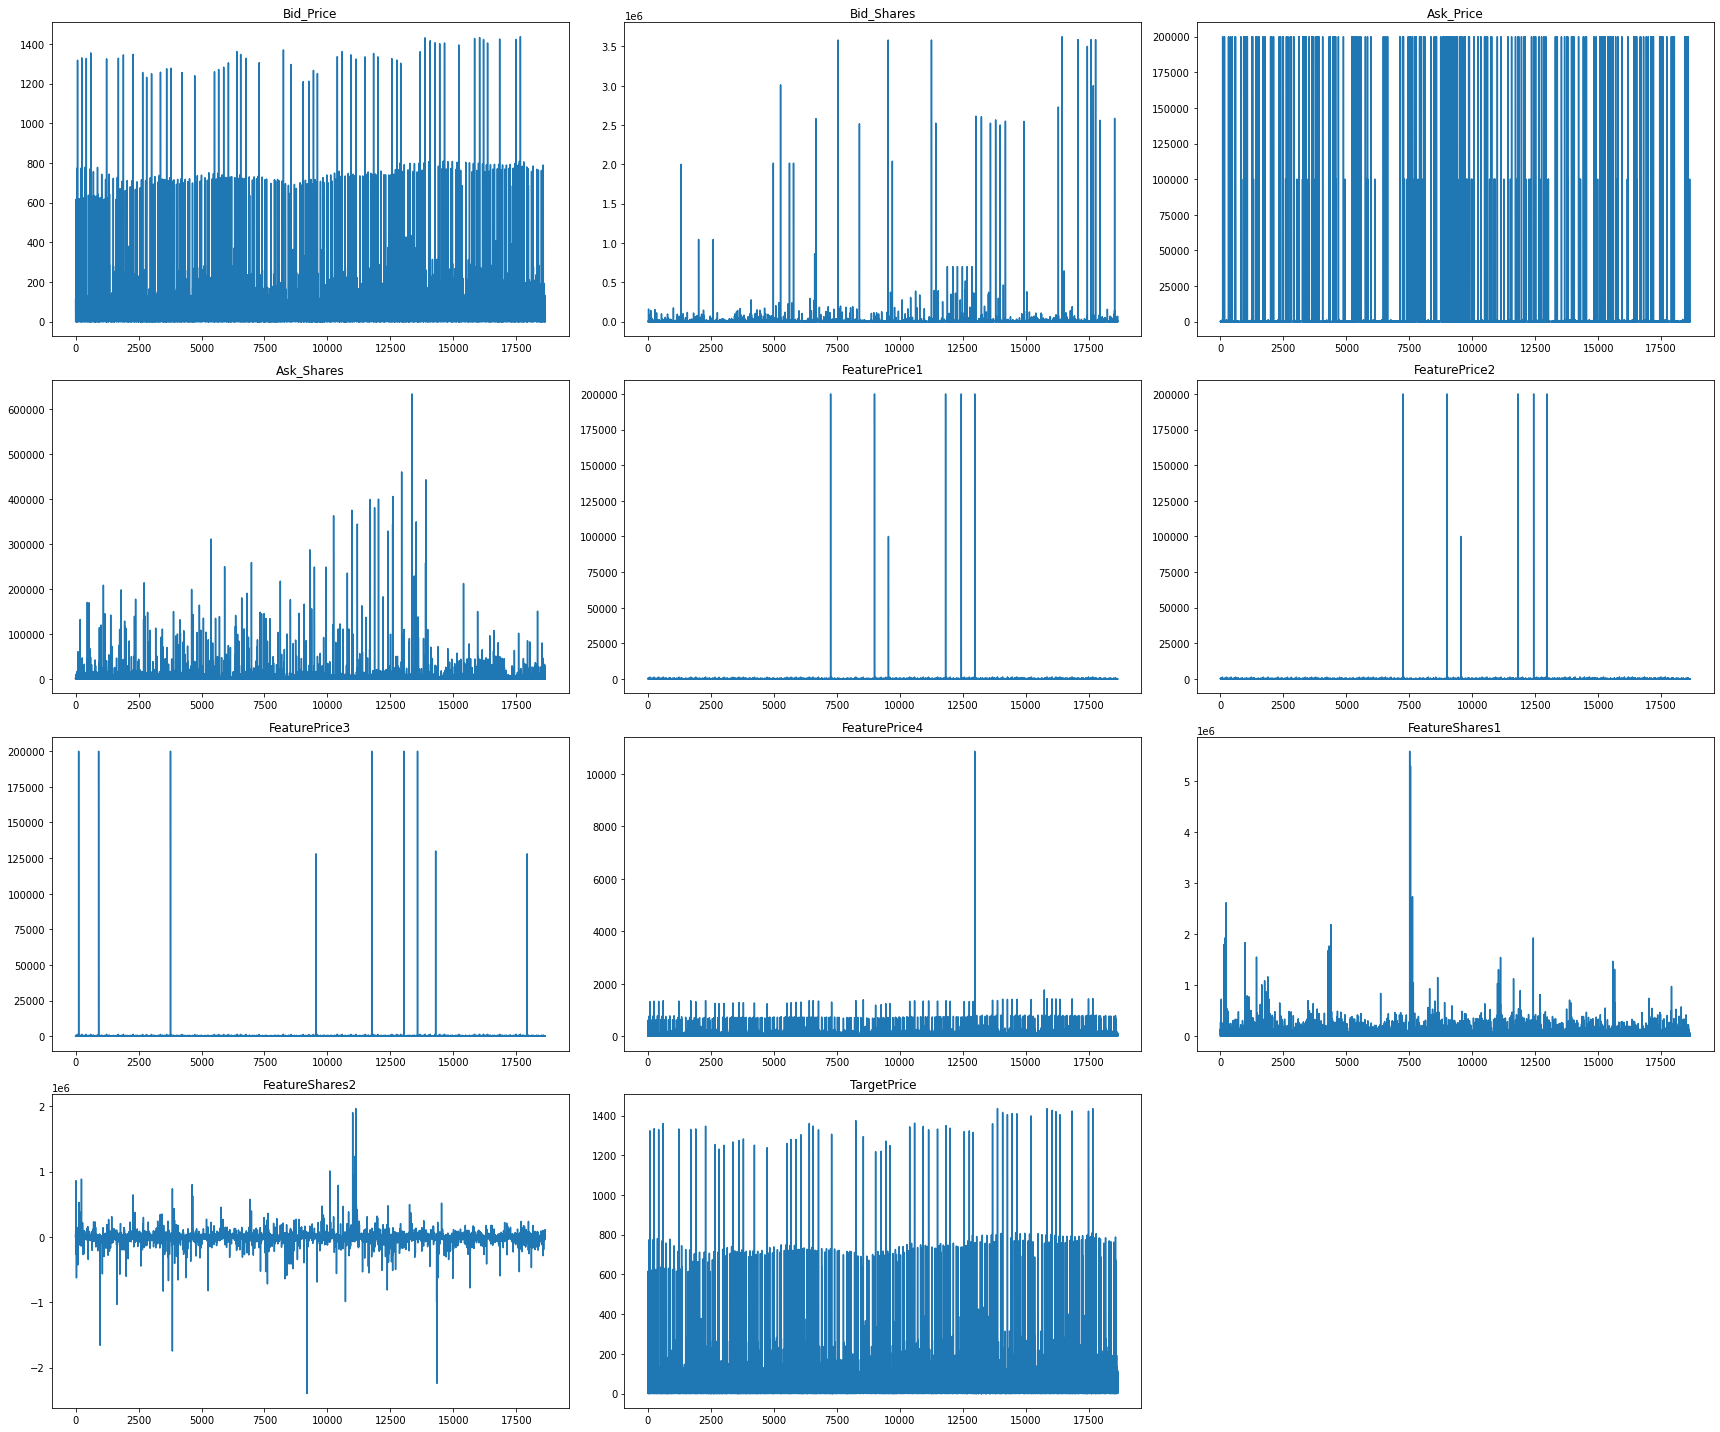

In [16]:
plot_lines(data.iloc[:, 1:])

And in the following :)

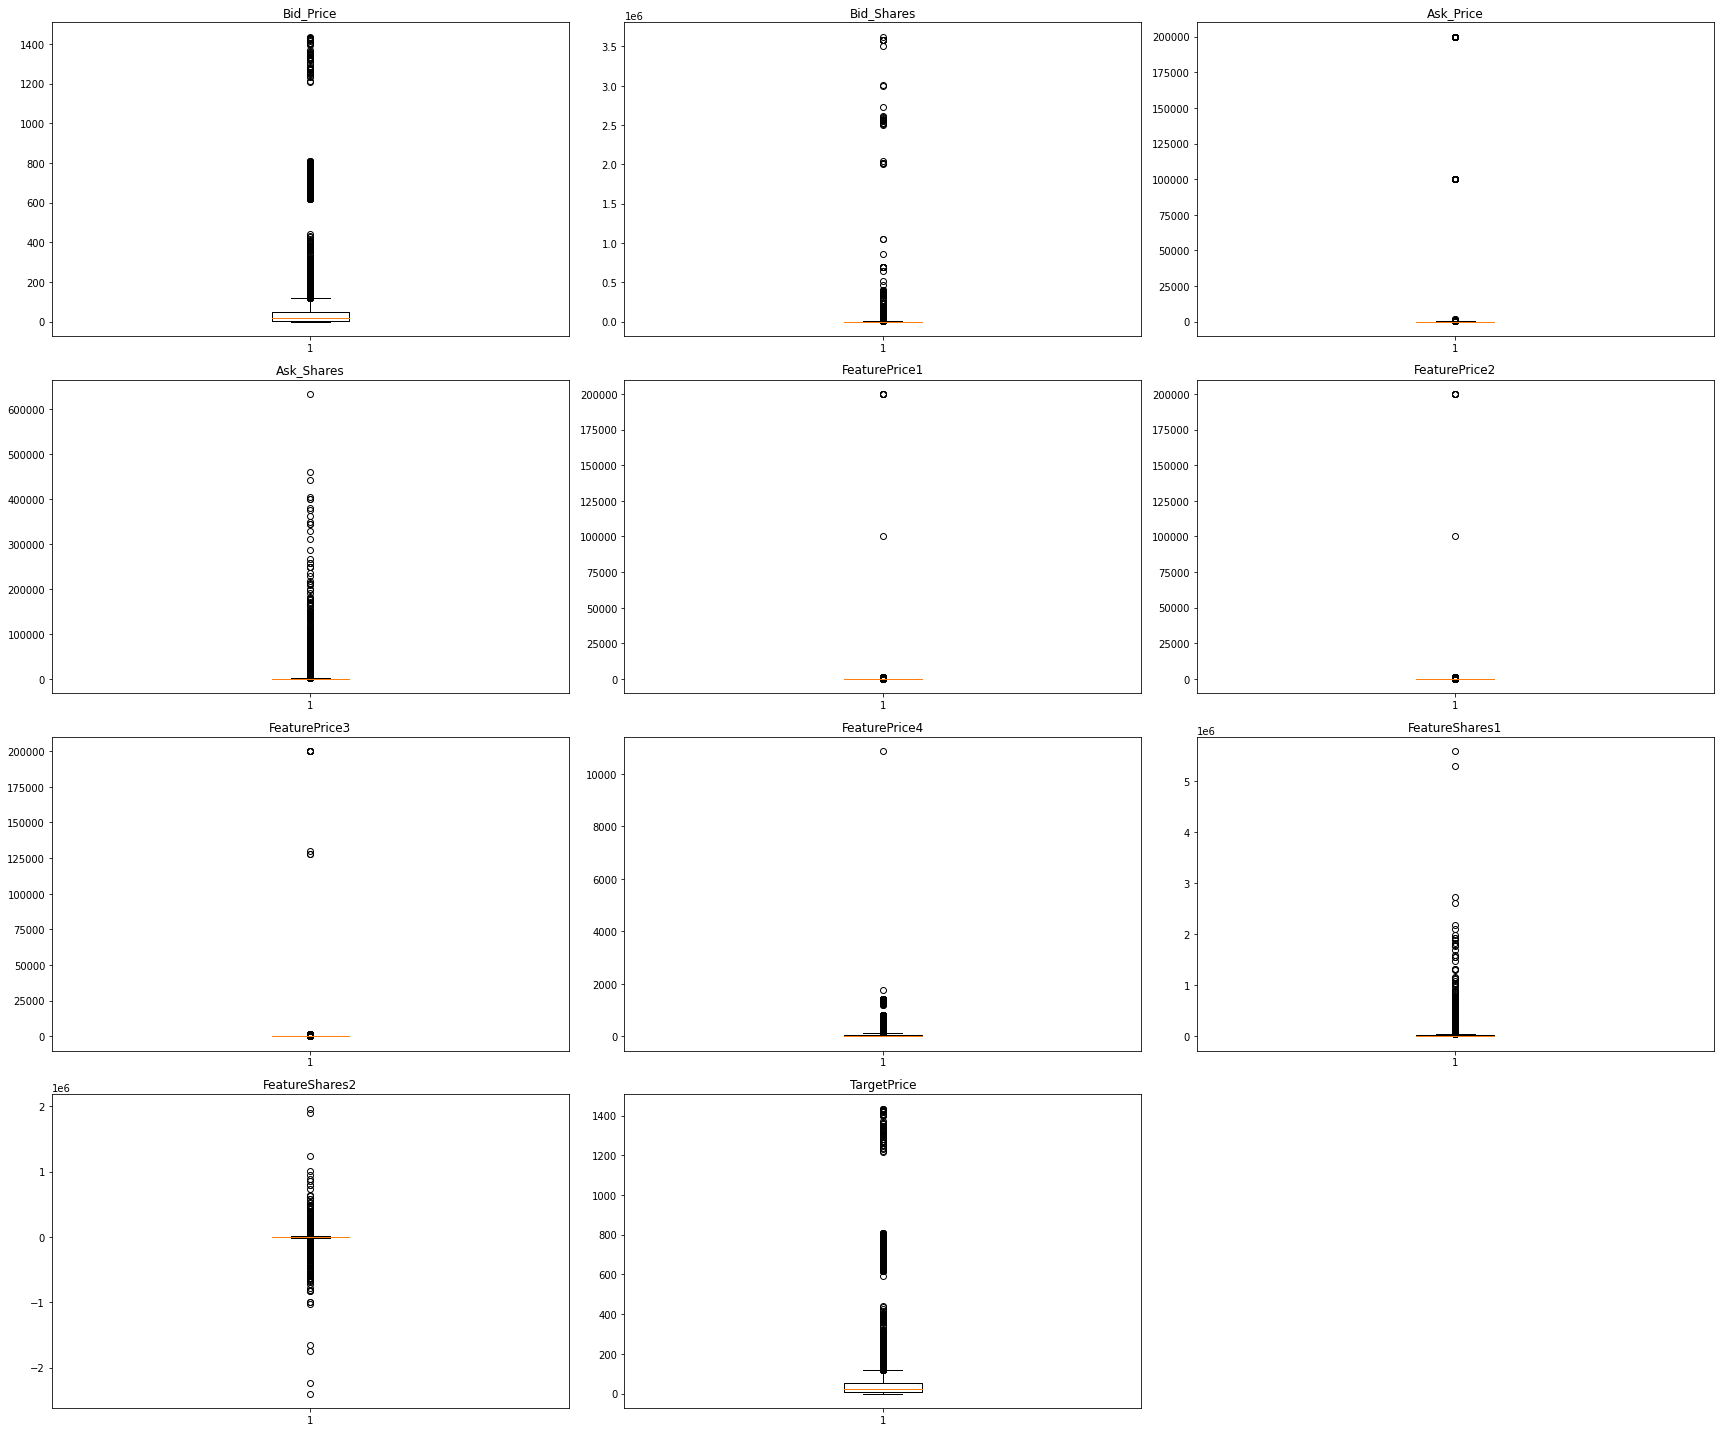

In [17]:
plot_boxes(data.iloc[:, 1:])

We can also numerically check how high the skewness is in our data.

In [18]:
data.iloc[:, 1:].skew().sort_values(ascending=False)

FeaturePrice2     58.054265
FeaturePrice1     58.054263
FeaturePrice3     47.553987
FeaturePrice4     26.793437
Bid_Shares        25.465688
FeatureShares1    21.491409
Ask_Shares        16.807873
Ask_Price          8.378450
Bid_Price          6.629375
TargetPrice        6.618099
FeatureShares2    -4.968618
dtype: float64

Let's show outliers in FeaturePrice1, FeaturePrice2, FeaturePrice3, FeaturePrice4 by identifying them using the three-sigma rule.

In [19]:
show_outliers(data, 'FeaturePrice2')

Number of outliers:  6



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
7252,2016-06-15,26.76,1200,27.05,1100,199999.99,199999.99,0.0,26.97,5394,116,26.50
8994,2016-06-28,8.65,8,199999.99,100,199999.99,199999.99,0.0,7.99,1939,562,8.46
9547,2016-07-01,0.01,200,100000.00,100,100000.00,100000.00,128000.0,10.10,0,95,10.14
11817,2016-07-21,0.01,100,199999.99,100,199999.99,199999.99,0.0,0.85,1425,1575,1.00
12439,2016-07-27,0.01,100,199999.99,100,199999.99,199999.99,0.0,6.90,200,150,7.50
12974,2016-07-29,0.00,0,0.00,0,199999.99,199999.99,0.0,10855.66,9705,16761,590.62


In [20]:
show_outliers(data, 'FeaturePrice1')

Number of outliers:  6



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
7252,2016-06-15,26.76,1200,27.05,1100,199999.99,199999.99,0.0,26.97,5394,116,26.50
8994,2016-06-28,8.65,8,199999.99,100,199999.99,199999.99,0.0,7.99,1939,562,8.46
9547,2016-07-01,0.01,200,100000.00,100,100000.00,100000.00,128000.0,10.10,0,95,10.14
11817,2016-07-21,0.01,100,199999.99,100,199999.99,199999.99,0.0,0.85,1425,1575,1.00
12439,2016-07-27,0.01,100,199999.99,100,199999.99,199999.99,0.0,6.90,200,150,7.50
12974,2016-07-29,0.00,0,0.00,0,199999.99,199999.99,0.0,10855.66,9705,16761,590.62


In [21]:
show_outliers(data, 'FeaturePrice3')

Number of outliers:  9



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
123,2016-04-14,27.56,200,82.67,200,82.65,82.67,199999.99,54.980,1000,377,55.28
916,2016-04-21,26.11,200,78.33,200,78.33,78.33,199999.99,52.290,0,300,52.13
3769,2016-05-16,23.69,300,71.05,300,71.05,71.05,199999.99,47.467,0,220,47.30
9547,2016-07-01,0.01,200,100000.00,100,100000.00,100000.00,128000.00,10.100,0,95,10.14
11759,2016-07-21,23.42,200,70.23,200,70.23,70.23,199999.99,46.920,771,529,47.23
13039,2016-08-01,19.86,200,40.00,29,40.00,40.40,199999.99,39.400,101,659,40.70
13577,2016-08-04,0.01,400,11.30,500,11.30,11.30,199999.99,10.570,200,1350,11.19
14297,2016-08-09,1.50,500,100000.00,100,1000.00,1000.00,130000.00,3.980,0,200,3.80
17930,2016-09-09,0.01,200,100000.00,100,11.81,11.81,128000.00,10.260,0,500,10.19


In [22]:
show_outliers(data, 'FeaturePrice4')

Number of outliers:  339



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice
9,2016-04-14,616.02,8,616.50,1700,616.50,616.61,616.61,614.82,25309,1443,616.50
48,2016-04-14,752.85,40,753.20,36,753.20,753.84,753.84,751.72,12055,2272,754.01
49,2016-04-14,773.28,2,774.24,100,774.14,774.58,774.63,771.91,12118,4099,775.07
79,2016-04-14,1318.00,18,1323.38,10,1322.88,1324.18,1324.18,1317.76,2898,563,1323.00
150,2016-04-15,619.60,15,620.00,505,620.00,621.11,621.11,620.75,153068,26969,621.92
205,2016-04-15,751.85,30,752.79,97,752.79,755.41,755.43,753.20,98175,41625,753.98
206,2016-04-15,773.60,100,774.50,36,774.50,776.53,776.53,775.39,98648,23725,775.50
247,2016-04-15,1330.00,110,1333.00,7,1333.00,1338.80,1338.95,1336.39,18710,3521,1333.67
310,2016-04-18,624.16,25,624.77,901,624.77,624.96,624.96,625.89,24853,2095,625.18
376,2016-04-18,758.29,2,758.46,100,758.46,759.06,759.06,759.00,10221,6708,760.46


Now let's calculate the sum of absolute differences between the features and the target to see which features are closest to it.

In [23]:
columns_to_get_diff = ['Bid_Price', 'Ask_Price', 'FeaturePrice1', 'FeaturePrice2', 'FeaturePrice3', 'FeaturePrice3']

for column in columns_to_get_diff:
  print(column, ': ', sum_difference(data[column], data['TargetPrice']), sep='', end='\n\n')

Bid_Price: 17767.73

Ask_Price: 50721336.99

FeaturePrice1: 1107033.58

FeaturePrice2: 1107110.2

FeaturePrice3: 1620528.74

FeaturePrice3: 1620528.74



Using linear regression, we identify the importance of each feature in relation to the target.

Feature: Bid_Price, Score: 0.95
Feature: Bid_Shares, Score: -0.0
Feature: Ask_Price, Score: 0.0
Feature: Ask_Shares, Score: -0.0
Feature: FeaturePrice1, Score: 0.25
Feature: FeaturePrice2, Score: -0.25
Feature: FeaturePrice3, Score: 0.0
Feature: FeaturePrice4, Score: 0.05
Feature: FeatureShares1, Score: -0.0
Feature: FeatureShares2, Score: 0.0


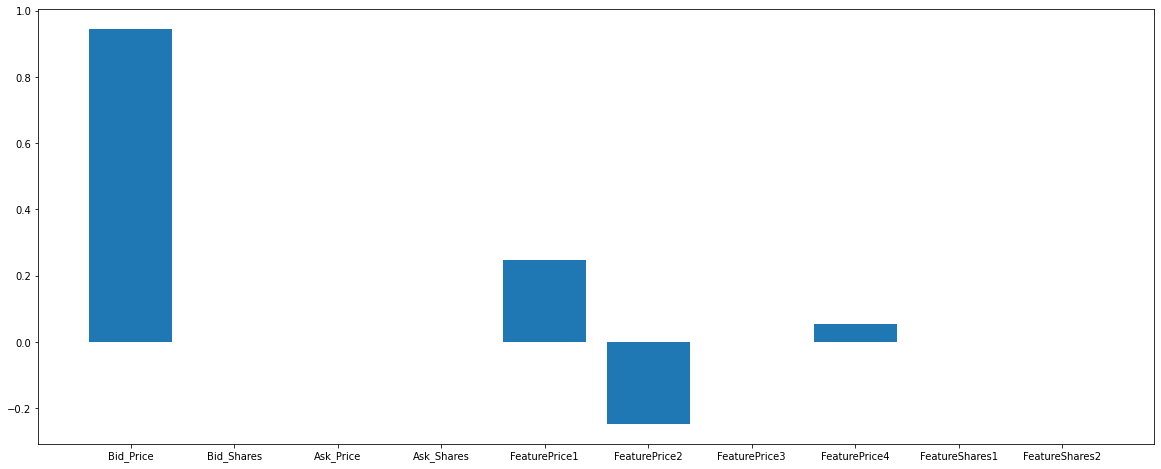

In [24]:
feature_importance(data.iloc[:, 1:-1], data.iloc[:, -1])

# Feature Engineering

Let's create a new dataset in which we fill in the outliers with the median for FeaturePrice1, FeaturePrice2, FeaturePrice3, FeaturePrice4 features.

We will also remove unnecessary features: Bid_Shares, Ask_Price, Ask_Shares, FeatureShares1, FeatureShares2.

In [25]:
data_updated_features = data.copy(deep=True)

columns_to_replace_outliers = ['FeaturePrice1', 'FeaturePrice2', 'FeaturePrice3', 'FeaturePrice4']
columns_to_remove = ['Bid_Shares', 'Ask_Price', 'Ask_Shares', 'FeatureShares1', 'FeatureShares2']

data_updated_features[columns_to_replace_outliers] = data_updated_features[columns_to_replace_outliers].apply(replace_outliers)
data_updated_features.drop(labels=columns_to_remove, axis=1, inplace=True)

In [26]:
data_updated_features

,Date,Bid_Price,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,TargetPrice
0,2016-04-14,111.58,111.5900,111.62,111.63,112.04,111.64
1,2016-04-14,5.10,5.1100,5.11,5.11,5.09,5.10
2,2016-04-14,12.80,13.7300,13.41,13.41,13.88,13.51
3,2016-04-14,58.38,59.1000,59.19,59.20,59.80,59.23
4,2016-04-14,43.88,44.0000,44.03,44.03,43.92,44.03
...,...,...,...,...,...,...,...
18646,2016-09-14,28.05,28.0500,27.97,27.97,28.00,28.00
18647,2016-09-14,116.14,116.2800,116.28,116.29,116.11,116.28
18648,2016-09-14,32.09,32.1000,32.42,32.49,31.57,32.12
18649,2016-09-14,0.64,0.6405,0.64,0.64,0.66,0.64


From the following visualizations, we can see that a linear relation between the updated features and the target is now clearly visible.

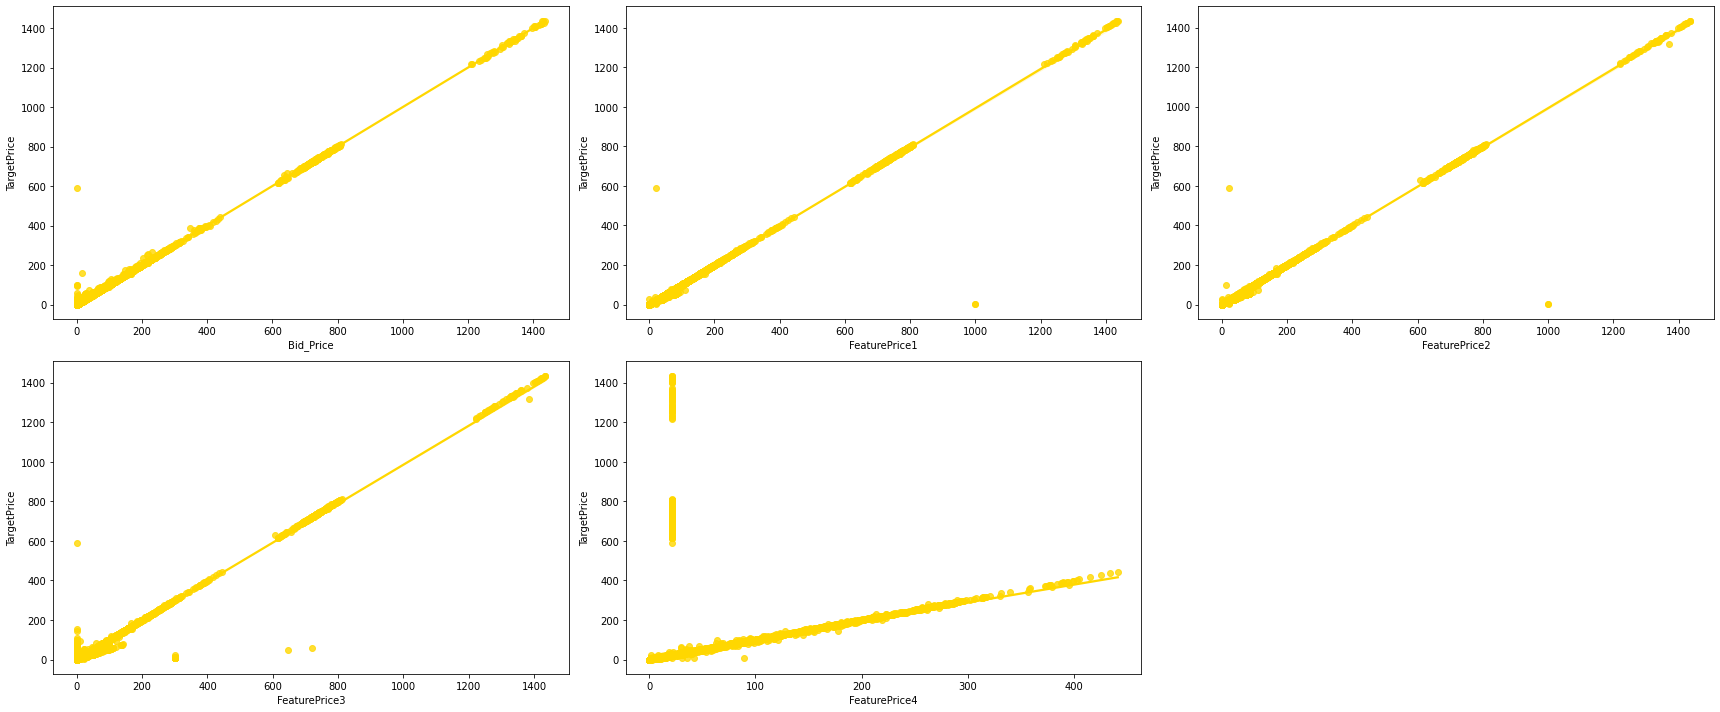

In [27]:
plot_regs(data_updated_features.iloc[:, 1:])

Also, we will check the rows where the Bid_Price value equals zero.

We see that, most likely, these are also outliers, because the values in other features are non-zero and are close to the values in the target. We can fill in these zeros with the median value of the rest of the features.

In [28]:
data_updated_features[data_updated_features['Bid_Price'] == 0].sort_values('TargetPrice', ascending=False).head(10)

,Date,Bid_Price,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,TargetPrice
12974,2016-07-29,0.0,21.62,21.59,0.00,21.670,590.62
14337,2016-08-09,0.0,99.99,13.00,0.00,84.760,99.99
14336,2016-08-09,0.0,101.86,101.86,10.09,110.510,94.73
12619,2016-07-27,0.0,16.25,16.25,302.00,1.850,22.59
12818,2016-07-28,0.0,20.00,20.00,10.26,21.670,20.00
9328,2016-06-29,0.0,13.50,13.50,302.00,12.280,13.50
7516,2016-06-16,0.0,13.50,13.50,302.00,16.350,13.50
16735,2016-08-29,0.0,10.02,10.02,302.00,19.505,13.01
18650,2016-09-14,0.0,12.70,12.70,302.00,13.040,12.70
5141,2016-05-27,0.0,12.55,12.56,0.00,12.560,12.56


In [29]:
data_updated_features['Bid_Price'] = data_updated_features['Bid_Price'].where(data_updated_features['Bid_Price'] != 0, data_updated_features[columns_to_replace_outliers].median(axis=1))

assert len(data_updated_features[data_updated_features['Bid_Price'] == 0]) == 0

We assume that the median of all features from the dataset above will be closer to the target.

Let's create a new dataset. 

In [30]:
data_updated_features_median = data_updated_features[['Date', 'TargetPrice']].copy(deep=True)

data_updated_features_median['Median'] = data_updated_features[['Bid_Price', 'FeaturePrice1', 'FeaturePrice2', 'FeaturePrice3', 'FeaturePrice4']].median(axis=1)
data_updated_features_median = data_updated_features_median.reindex(columns=['Date', 'Median', 'TargetPrice'])

In [31]:
data_updated_features_median.head()

,Date,Median,TargetPrice
0,2016-04-14,111.62,111.64
1,2016-04-14,5.11,5.10
2,2016-04-14,13.41,13.51
3,2016-04-14,59.19,59.23
4,2016-04-14,44.00,44.03


Yes it's true:)

In [32]:
sum_difference(data_updated_features_median['Median'], data_updated_features_median['TargetPrice'])

4983.8

In addition, from the following visualizations, we can see that we got rid of the outliers to some extent.

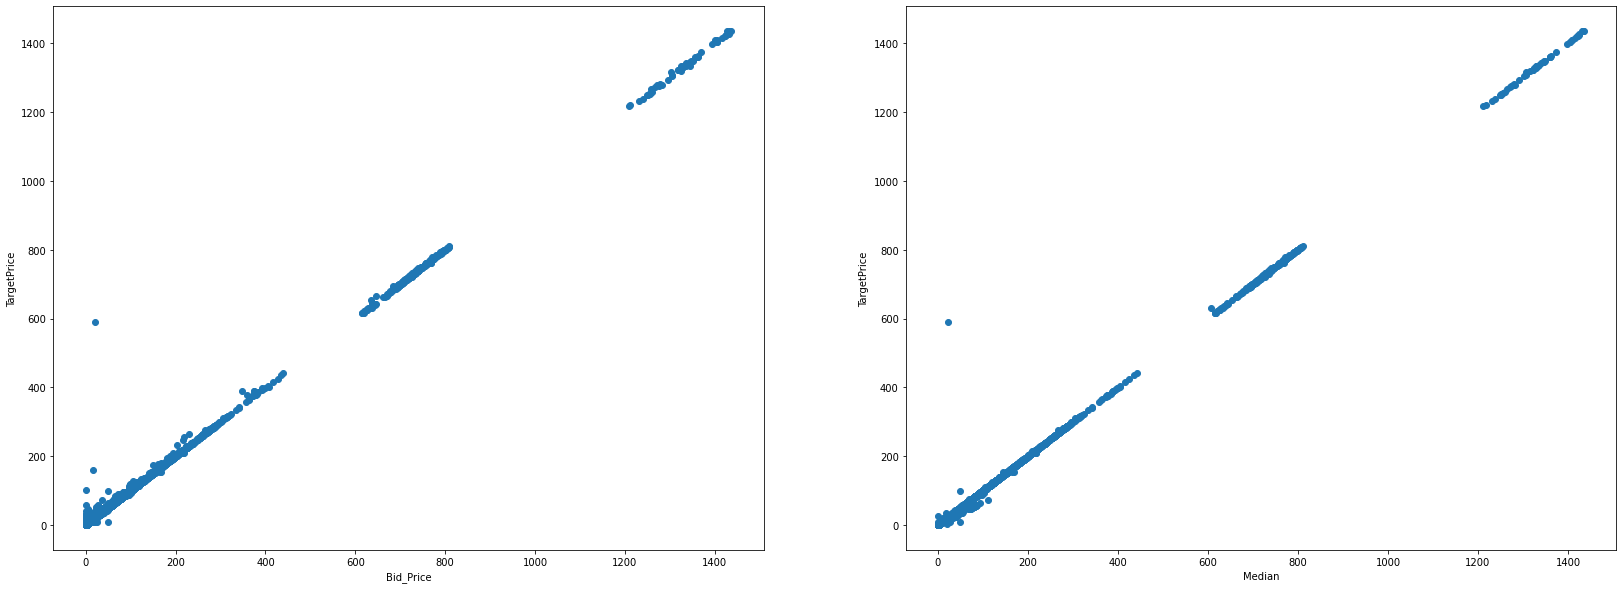

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 10))

ax1.scatter(data_updated_features['Bid_Price'], data_updated_features['TargetPrice'])
ax1.set_xlabel('Bid_Price')
ax1.set_ylabel('TargetPrice')

ax2.scatter(data_updated_features_median['Median'], data_updated_features['TargetPrice'])
ax2.set_xlabel('Median')
ax2.set_ylabel('TargetPrice')

plt.show()

From the visualizations we made earlier, we remember that the features have a non-normal distribution, let's correct this using logarithm.

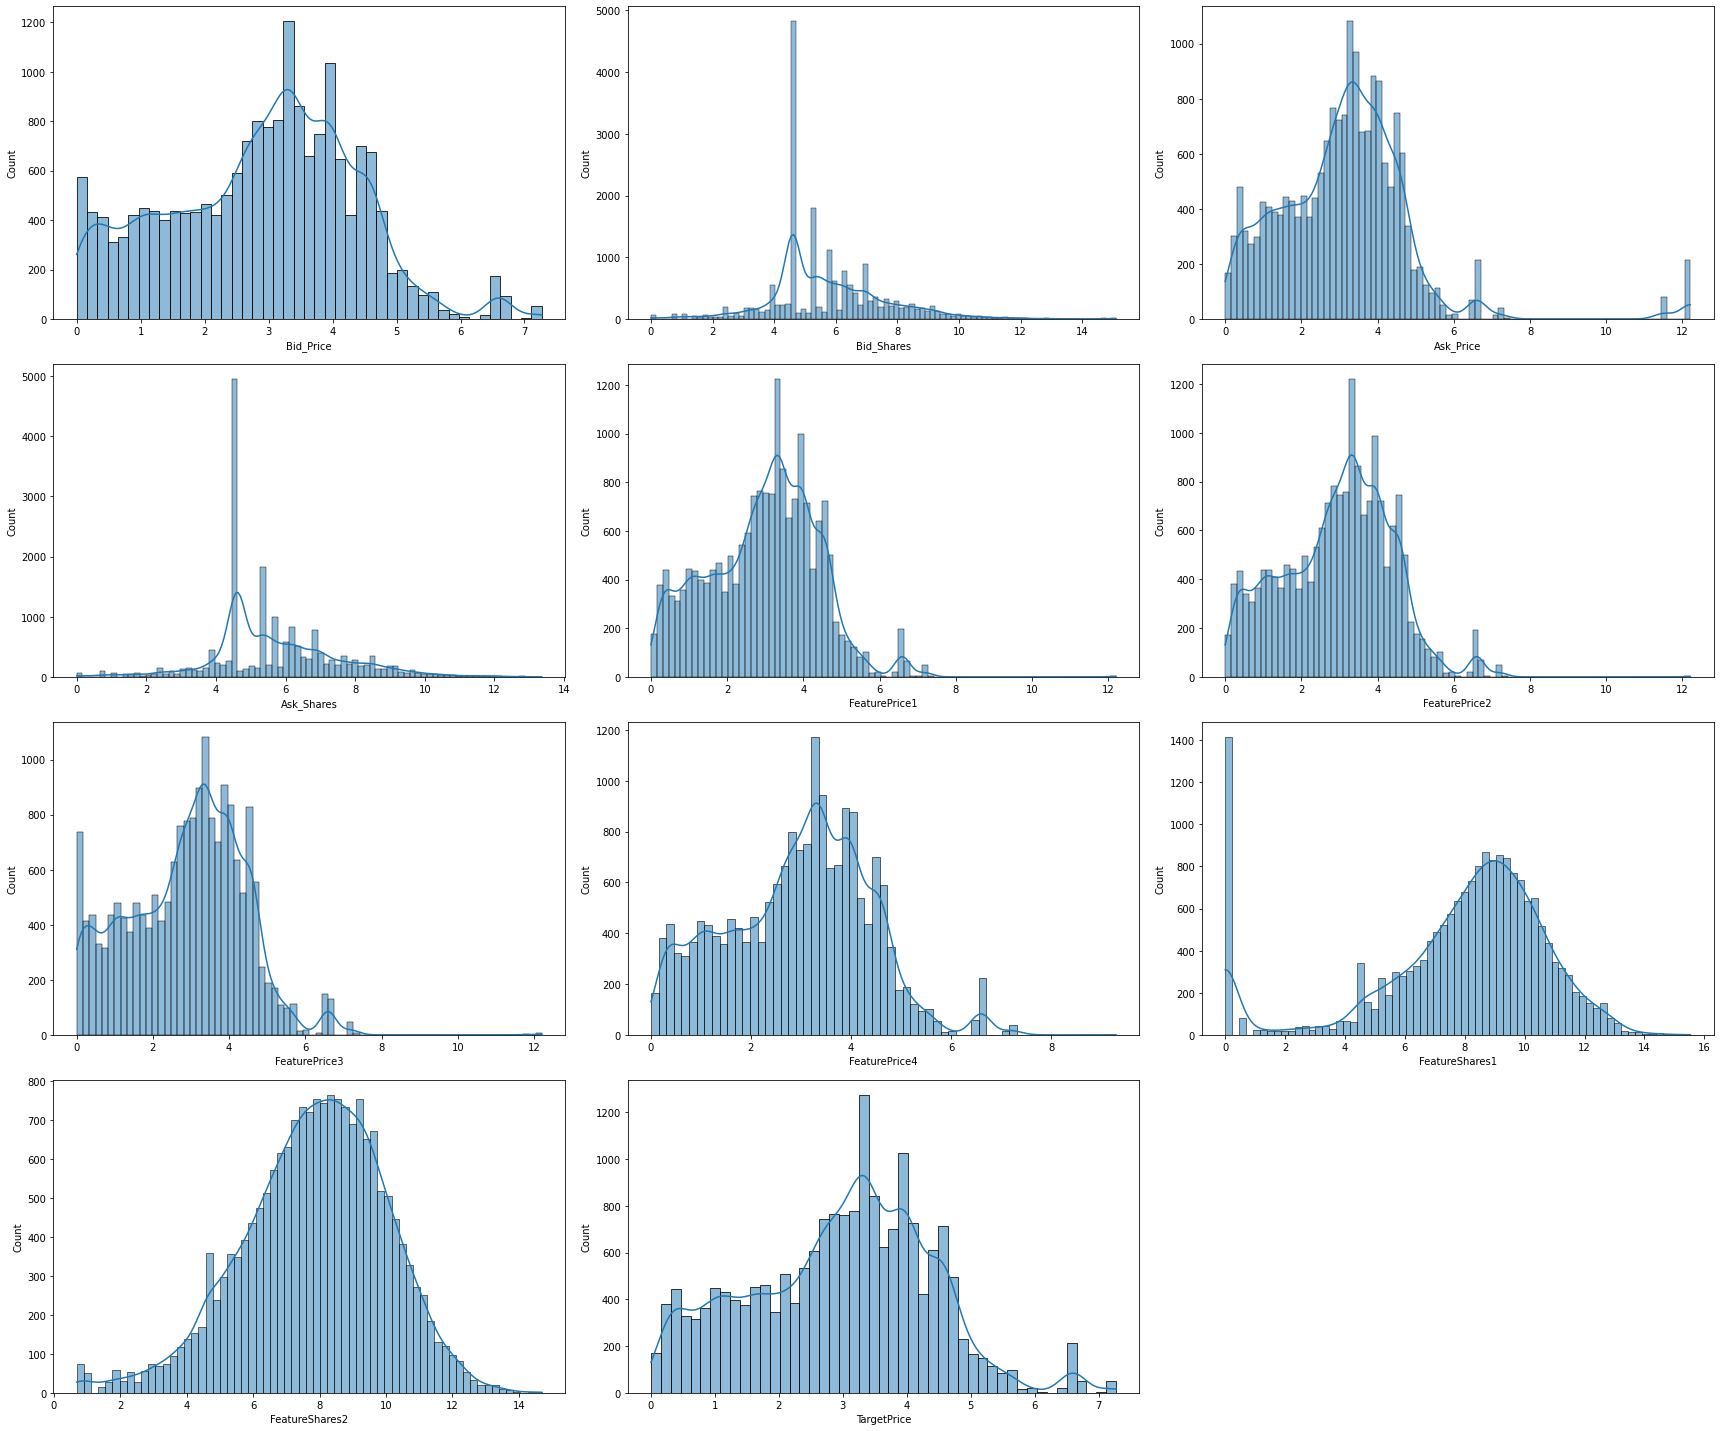

In [34]:
data_normalized = normalize_data(data)
plot_dists(data_normalized.iloc[:, 1:])

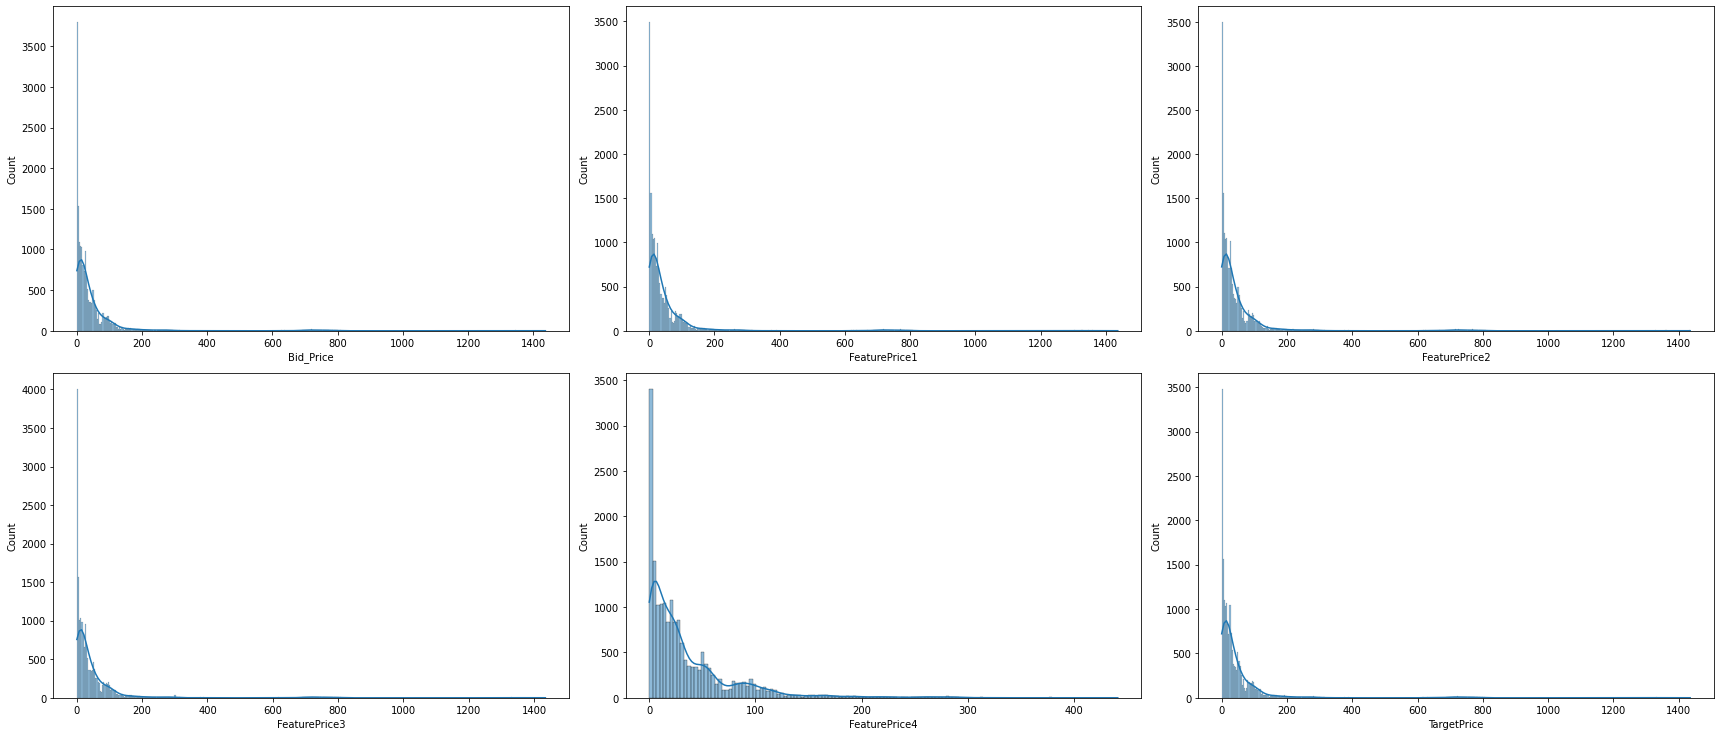

In [35]:
plot_dists(data_updated_features.iloc[:, 1:])

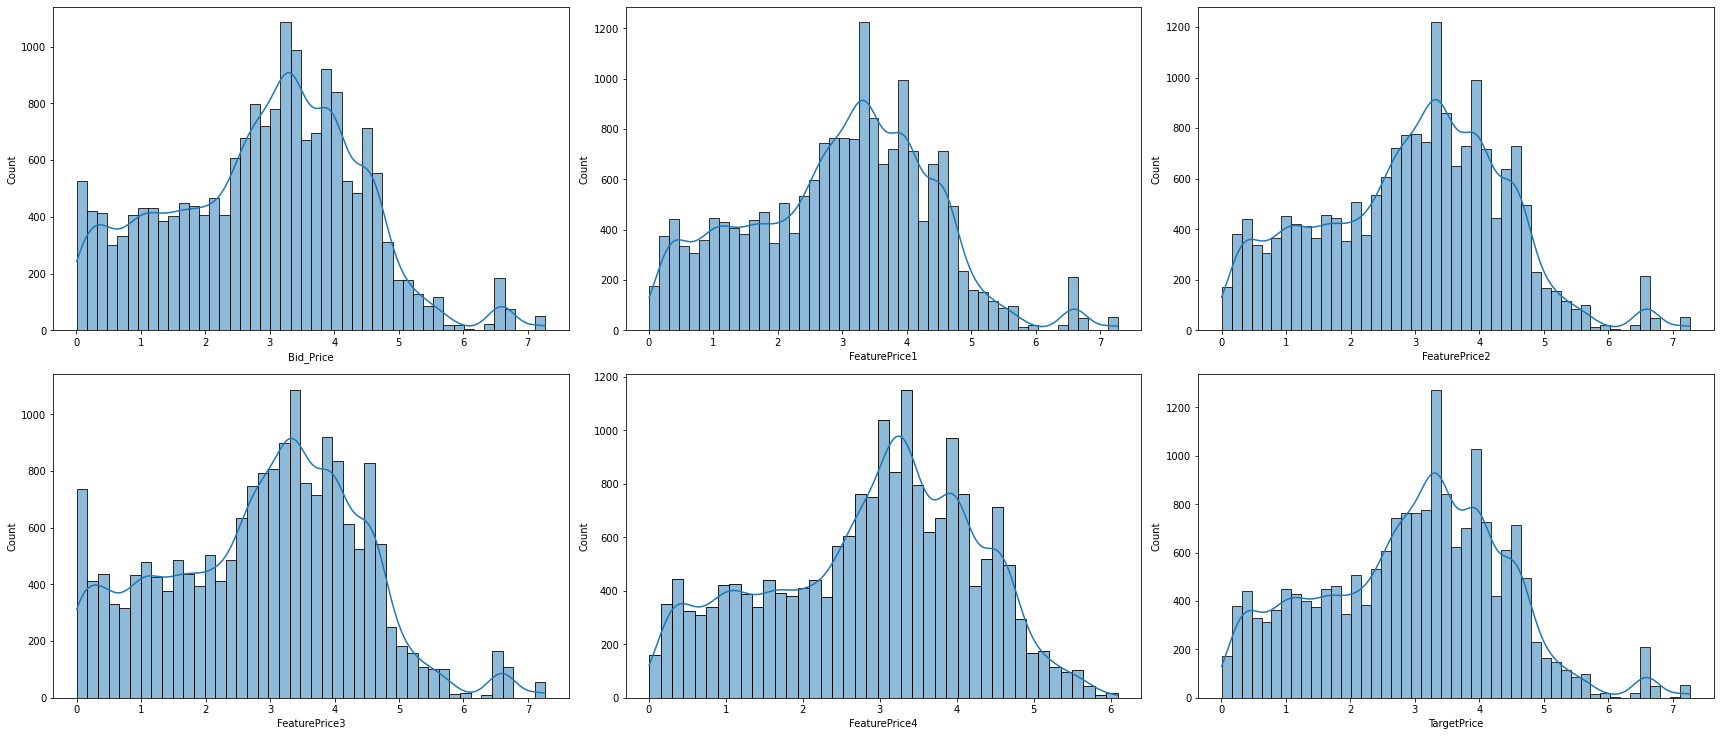

In [36]:
data_updated_features_normalized = normalize_data(data_updated_features)
plot_dists(data_updated_features_normalized.iloc[:, 1:])

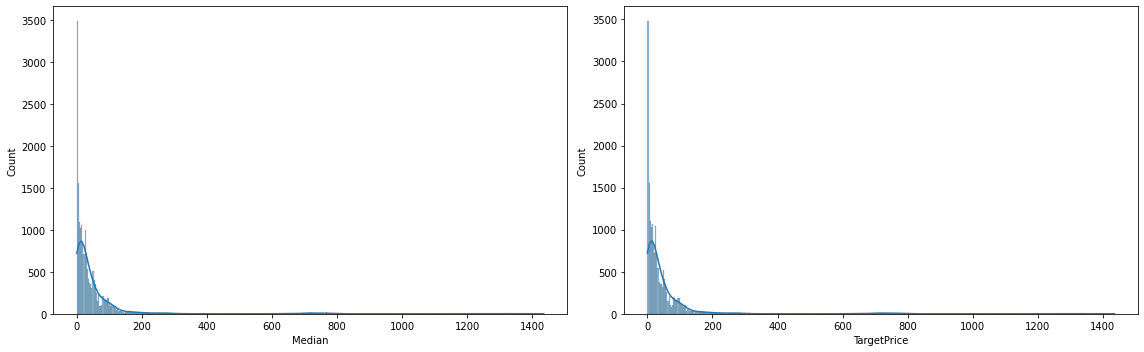

In [37]:
plot_dists(data_updated_features_median.iloc[:, 1:])

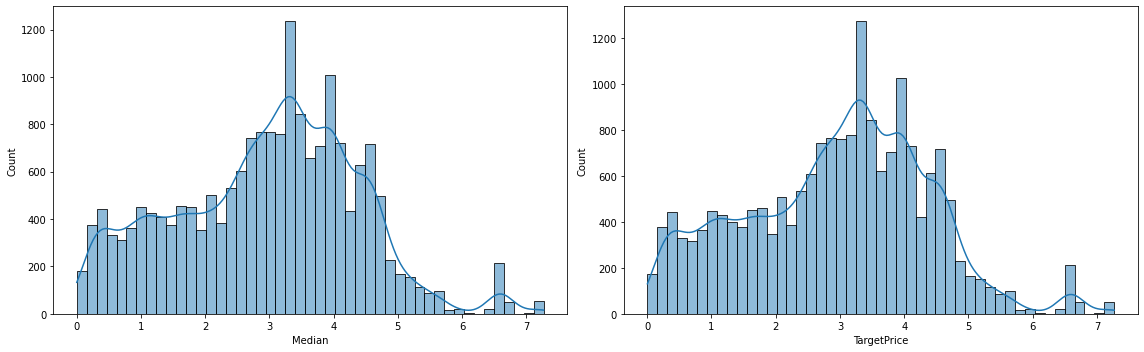

In [38]:
data_updated_features_median_normalized = normalize_data(data_updated_features_median)
plot_dists(data_updated_features_median_normalized.iloc[:, 1:])

# Experiments Execution

It was decided to conduct some experiments.

We created 6 datasets (Dataset dict), 8 machine learning models (ML_models dict), 3 deep learning models (DL_models dict). We will also use several splits into training and test datasets (Splits list), as well as scaling to a standard normal distribution (Scales list).

We have previously normalized the data, but it can also be scaled to the standard normal form, which can affect the quality of the model.

In [39]:
Datasets = {'Data Initial': data,
            'Data Normalized': data_normalized,
            'Data Updated Features': data_updated_features,
            'Data Updated Features Normalized': data_updated_features_normalized,
            'Data Updated Features Median': data_updated_features_median,
            'Data Updated Features Median Normalized': data_updated_features_median_normalized}

ML_models = {'LinearRegression': LinearRegression(),
             'Lasso': Lasso(alpha=0.5),
             'Ridge': Ridge(alpha=1),
             'ElasticNet': ElasticNet(alpha=1, l1_ratio=0.5),
             'DecisionTreeRegressor' : DecisionTreeRegressor(),
             'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
             'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100),
             'AdaBoostRegressor' : AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=100)}

DL_models = {'Dense': dense_nn_model,
             'LSTM': lstm_nn_model,
             'GRU': gru_nn_model}

Splits = [0.7, 0.8]

Scales = [True, False]

In [40]:
def run():
  results = pd.DataFrame(columns=['ModelType', 'Model', 'Dataset', 'Split', 'IsScaled', 'RSquaredTrain', 'RSquaredTest', 'MeanSquaredError', 'RootMeanSquaredError', 'MeanAbsoluteError'])

  try:
    print('Machine Learning Models')
    for model_name, model in ML_models.items():
      for dataset_name, dataset in Datasets.items():
        for split in Splits:
          for scale in Scales:
            print(f'Model: {model_name}', f'Dataset: {dataset_name}', f'Split: {split}', f'Scale: {scale}', sep='\n')

            X_train, X_test, y_train, y_test = split_dataset(dataset, train_split=split)
            train_score, test_score, mse, rmse, mae = fit_ml_model(model, X_train, X_test, y_train, y_test, scaled=scale)

            result = {'ModelType': 'Machine Learning Model',
                      'Model': model_name,
                      'Dataset': dataset_name,
                      'Split': split,
                      'IsScaled': scale,
                      'RSquaredTrain': train_score,
                      'RSquaredTest': test_score,
                      'MeanSquaredError': mse,
                      'RootMeanSquaredError': rmse,
                      'MeanAbsoluteError': mae}
            
            results = results.append(result, ignore_index=True)

            print('DONE', end='\n\n')
      print('\n')


    print('\n\n')

    print('Deep Learning Models')
    for model_name, model in DL_models.items():
      for dataset_name, dataset in Datasets.items():
        print(f'Model: {model_name}', f'Dataset: {dataset_name}', f'Split: {(split := 0.8)}', f'Scale: {(scale := False)}', sep='\n')

        X_train, X_test, y_train, y_test = split_dataset(dataset, train_split=split)
        train_score, test_score, mse, rmse, mae = fit_nn_model(model, X_train, X_test, y_train, y_test, scaled=scale)

        result = {'ModelType': 'Deep Learning Model',
                  'Model': model_name,
                  'Dataset': dataset_name,
                  'Split': split,
                  'IsScaled': scale,
                  'RSquaredTrain': train_score,
                  'RSquaredTest': test_score,
                  'MeanSquaredError': mse,
                  'RootMeanSquaredError': rmse,
                  'MeanAbsoluteError': mae}
        
        results = results.append(result, ignore_index=True)

        print('DONE', end='\n\n')
    
      print('\n\n')
  
  except Exception as e:
    print('ERROR:', e)

  return results

The execution of the next cell takes more than 2 hours using the CPU.

Approximately 1 hour on the GPU.


In [41]:
results = run()

Machine Learning Models
Model: LinearRegression
Dataset: Data Initial
Split: 0.7
Scale: True
DONE

Model: LinearRegression
Dataset: Data Initial
Split: 0.7
Scale: False
DONE

Model: LinearRegression
Dataset: Data Initial
Split: 0.8
Scale: True
DONE

Model: LinearRegression
Dataset: Data Initial
Split: 0.8
Scale: False
DONE

Model: LinearRegression
Dataset: Data Normalized
Split: 0.7
Scale: True
DONE

Model: LinearRegression
Dataset: Data Normalized
Split: 0.7
Scale: False
DONE

Model: LinearRegression
Dataset: Data Normalized
Split: 0.8
Scale: True
DONE

Model: LinearRegression
Dataset: Data Normalized
Split: 0.8
Scale: False
DONE

Model: LinearRegression
Dataset: Data Updated Features
Split: 0.7
Scale: True
DONE

Model: LinearRegression
Dataset: Data Updated Features
Split: 0.7
Scale: False
DONE

Model: LinearRegression
Dataset: Data Updated Features
Split: 0.8
Scale: True
DONE

Model: LinearRegression
Dataset: Data Updated Features
Split: 0.8
Scale: False
DONE

Model: LinearRegressio

The dataset contains information related to bids and asks for a particular stock on a given date, as well as additional features that could potentially impact the stock price.

Here is a breakdown of each column:



1.   Date: The date of the stock market activity.
2.   Bid_Price: The highest price that a buyer is willing to pay for the stock at the time the data was recorded.
3. Bid_Shares: The number of shares that buyers are willing to purchase at the Bid_Price at the time the data was recorded.
4. Ask_Price: The lowest price that a seller is willing to sell the stock for at the time the data was recorded.
5. Ask_Shares: The number of shares that sellers are willing to sell at the Ask_Price at the time the data was recorded.
6. FeaturePrice1-4: Four additional features that could potentially impact the stock price.
7. FeatureShares1-2: Two additional features that likely represent the number of shares related to the FeaturePrice features.
8. TargetPrice: The actual price that the stock closed at on the date recorded.












Description for each dataset:

1. Data Initial - the initial dataset, which was not changed at all.
2. Data Normalized - the initial dataset, the features of which have been normalized.
3. Data Updated Features - the subset of initial dataset consisting of Bid_Price, FeaturePrice1, FeaturePrice2, FeaturePrice3, FeaturePrice4, TargetPrice.
4. Data Updated Features Normalized - the subset of initial dataset consisting of Bid_Price, FeaturePrice1, FeaturePrice2, FeaturePrice3, FeaturePrice4, TargetPrice. Features were normalized.
5. Data Updated Features Median - the dataset that consists of only two features: Median and TargetPrice. Where Median is the median of all features except TargetPrice from the Data Updated Features dataset.
6. Data Updated Features Median Normalized - the dataset that consists of only two features: Median and TargetPrice. Where Median is the median of all features except TargetPrice from the Data Updated Features dataset. Features were normalized.


Presumably, all features that have the word 'Shares' in their names do not affect the target at all.

### Analysis of results

From the following tables, we can see that almost all the methods shown the great quality of forecasting.

But the best is AdaBoostRegressor with normalized initial dataset, 0.8 split, unscaled.

Let's use it to make prediction on our test dataset.

In [50]:
results.sort_values(by=['MeanSquaredError'], ascending=True)

,ModelType,Model,Dataset,Split,IsScaled,RSquaredTrain,RSquaredTest,MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError
175,Machine Learning Model,AdaBoostRegressor,Data Normalized,0.8,False,0.999988,0.999740,0.000525,0.022904,0.007102
173,Machine Learning Model,AdaBoostRegressor,Data Normalized,0.7,False,0.999989,0.999703,0.000604,0.024575,0.007285
181,Machine Learning Model,AdaBoostRegressor,Data Updated Features Normalized,0.7,False,0.999987,0.999655,0.000702,0.026495,0.007168
174,Machine Learning Model,AdaBoostRegressor,Data Normalized,0.8,True,0.999989,0.999638,0.000730,0.027018,0.007033
180,Machine Learning Model,AdaBoostRegressor,Data Updated Features Normalized,0.7,True,0.999986,0.999629,0.000755,0.027479,0.007238
...,...,...,...,...,...,...,...,...,...,...
90,Machine Learning Model,ElasticNet,Data Updated Features Median,0.8,True,0.554235,0.554988,6532.162409,80.821794,34.913472
88,Machine Learning Model,ElasticNet,Data Updated Features Median,0.7,True,0.554020,0.554980,6633.954795,81.449093,35.327623
198,Deep Learning Model,LSTM,Data Initial,0.8,False,0.308756,0.301868,10247.611533,101.230487,16.127129
200,Deep Learning Model,LSTM,Data Updated Features,0.8,False,0.308282,0.301109,10258.748621,101.285481,15.912685


In [51]:
results.sort_values(by=['RSquaredTest', 'MeanSquaredError', 'RootMeanSquaredError', 'MeanAbsoluteError', 'RSquaredTrain'], ascending=[False, True, True, True, False]).head(30)

,ModelType,Model,Dataset,Split,IsScaled,RSquaredTrain,RSquaredTest,MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError
178,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,True,0.999996,0.999908,1.348780,1.161370,0.263201
179,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,False,0.999997,0.999900,1.472702,1.213549,0.250091
106,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,True,1.000000,0.999885,1.682297,1.297034,0.250963
107,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,False,1.000000,0.999868,1.941686,1.393444,0.263345
65,Machine Learning Model,Ridge,Data Updated Features Median,0.7,False,0.998026,0.999833,2.488919,1.577631,0.243256
17,Machine Learning Model,LinearRegression,Data Updated Features Median,0.7,False,0.998026,0.999833,2.488919,1.577631,0.243257
16,Machine Learning Model,LinearRegression,Data Updated Features Median,0.7,True,0.998026,0.999833,2.488919,1.577631,0.243257
41,Machine Learning Model,Lasso,Data Updated Features Median,0.7,False,0.998026,0.999833,2.488920,1.577631,0.242543
89,Machine Learning Model,ElasticNet,Data Updated Features Median,0.7,False,0.998026,0.999833,2.488962,1.577644,0.241851
64,Machine Learning Model,Ridge,Data Updated Features Median,0.7,True,0.998026,0.999833,2.488969,1.577647,0.241766


# Test Dataset Prediction

Let's check what the test data looks like.

In [52]:
test.head(10)

,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
0,2016-09-15,3.05,200,4.63,100,3.45,3.45,0.00,3.47,0,11
1,2016-09-15,113.77,100,113.77,600,113.77,113.61,113.61,111.77,626338,-168775
2,2016-09-15,2.24,100,2.58,952,2.24,2.24,2.24,2.24,1560,-219
3,2016-09-15,3.62,100,3.64,200,3.64,3.66,3.66,3.28,34475,12846
4,2016-09-15,6.56,100,6.70,51,6.56,6.48,6.48,6.07,2536,-8063
5,2016-09-15,20.24,100,27.00,101,25.94,26.02,26.02,25.74,9127,1630
6,2016-09-15,97.61,90,98.50,2,98.56,98.86,98.86,98.79,32805,11383
7,2016-09-15,34.65,600,34.73,500,34.65,34.00,33.10,21.13,103858,-35999
8,2016-09-15,46.25,2100,46.38,50,46.38,47.20,47.47,45.26,30148,28938
9,2016-09-15,6.15,2100,6.18,8800,6.15,6.15,6.12,6.13,0,-115


In [53]:
test.describe().round(1)

,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
count,3907.0,3907.0,3907.0,3907.0,3907.0,3907.0,3907.0,3907.0,3907.0,3907.0
mean,46.5,7627.5,2761.7,2568.0,124.3,124.3,336.9,47.6,29124.1,-1490.2
std,111.4,115193.1,22114.7,13106.4,3577.7,3577.7,7436.4,112.3,157841.8,47624.8
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1009200.0
25%,4.6,100.0,5.7,100.0,5.5,5.4,4.5,5.4,518.5,-2630.5
50%,18.0,200.0,21.6,200.0,19.4,19.4,19.0,19.2,4231.0,34.0
75%,48.9,1000.0,53.1,1000.0,49.9,50.0,49.9,50.0,18045.0,2341.0
max,1488.0,3584800.0,200000.0,339456.0,200000.0,200000.0,200000.0,1486.7,7335035.0,550198.0


In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3907 entries, 0 to 3906
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            3907 non-null   object 
 1   Bid_Price       3907 non-null   float64
 2   Bid_Shares      3907 non-null   int64  
 3   Ask_Price       3907 non-null   float64
 4   Ask_Shares      3907 non-null   int64  
 5   FeaturePrice1   3907 non-null   float64
 6   FeaturePrice2   3907 non-null   float64
 7   FeaturePrice3   3907 non-null   float64
 8   FeaturePrice4   3907 non-null   float64
 9   FeatureShares1  3907 non-null   int64  
 10  FeatureShares2  3907 non-null   int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 335.9+ KB


In [55]:
test['Date'].value_counts()

2016-09-16    232
2016-09-19    214
2016-09-21    202
2016-09-26    200
2016-10-13    200
2016-10-03    187
2016-10-06    185
2016-10-10    184
2016-09-22    184
2016-09-20    177
2016-09-28    175
2016-09-29    173
2016-10-11    172
2016-09-27    166
2016-10-07    163
2016-09-30    163
2016-10-04    161
2016-09-23    158
2016-09-15    155
2016-10-14    154
2016-10-05    153
2016-10-12    149
Name: Date, dtype: int64

In [56]:
test['Date'].nunique()

22

<AxesSubplot:>

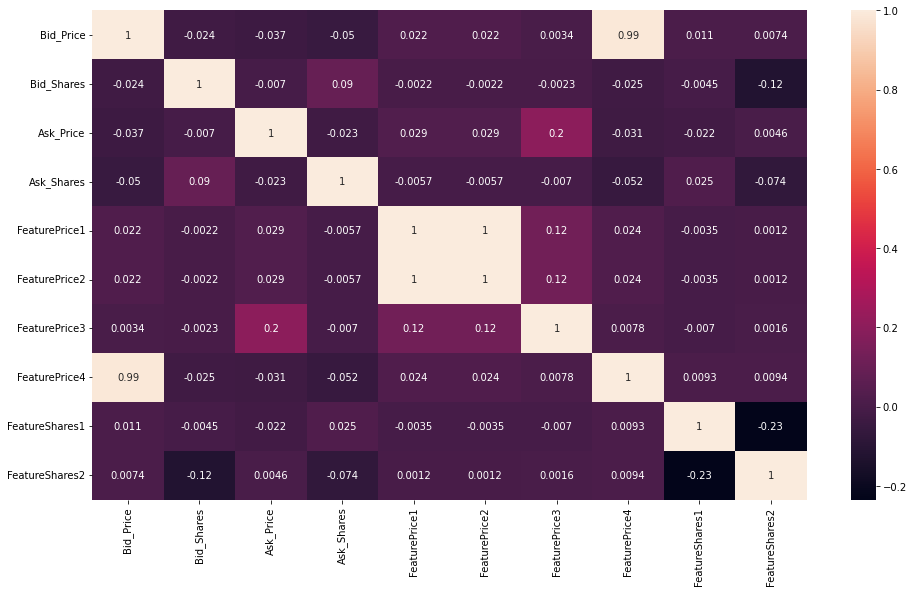

In [57]:
plt.figure(figsize=(16, 9))
sns.heatmap(test.corr(), annot=True)

In [58]:
px.scatter_matrix(data_frame=test.iloc[:, 1:], dimensions=test.iloc[:, 1:].columns, width=1600, height=1600)

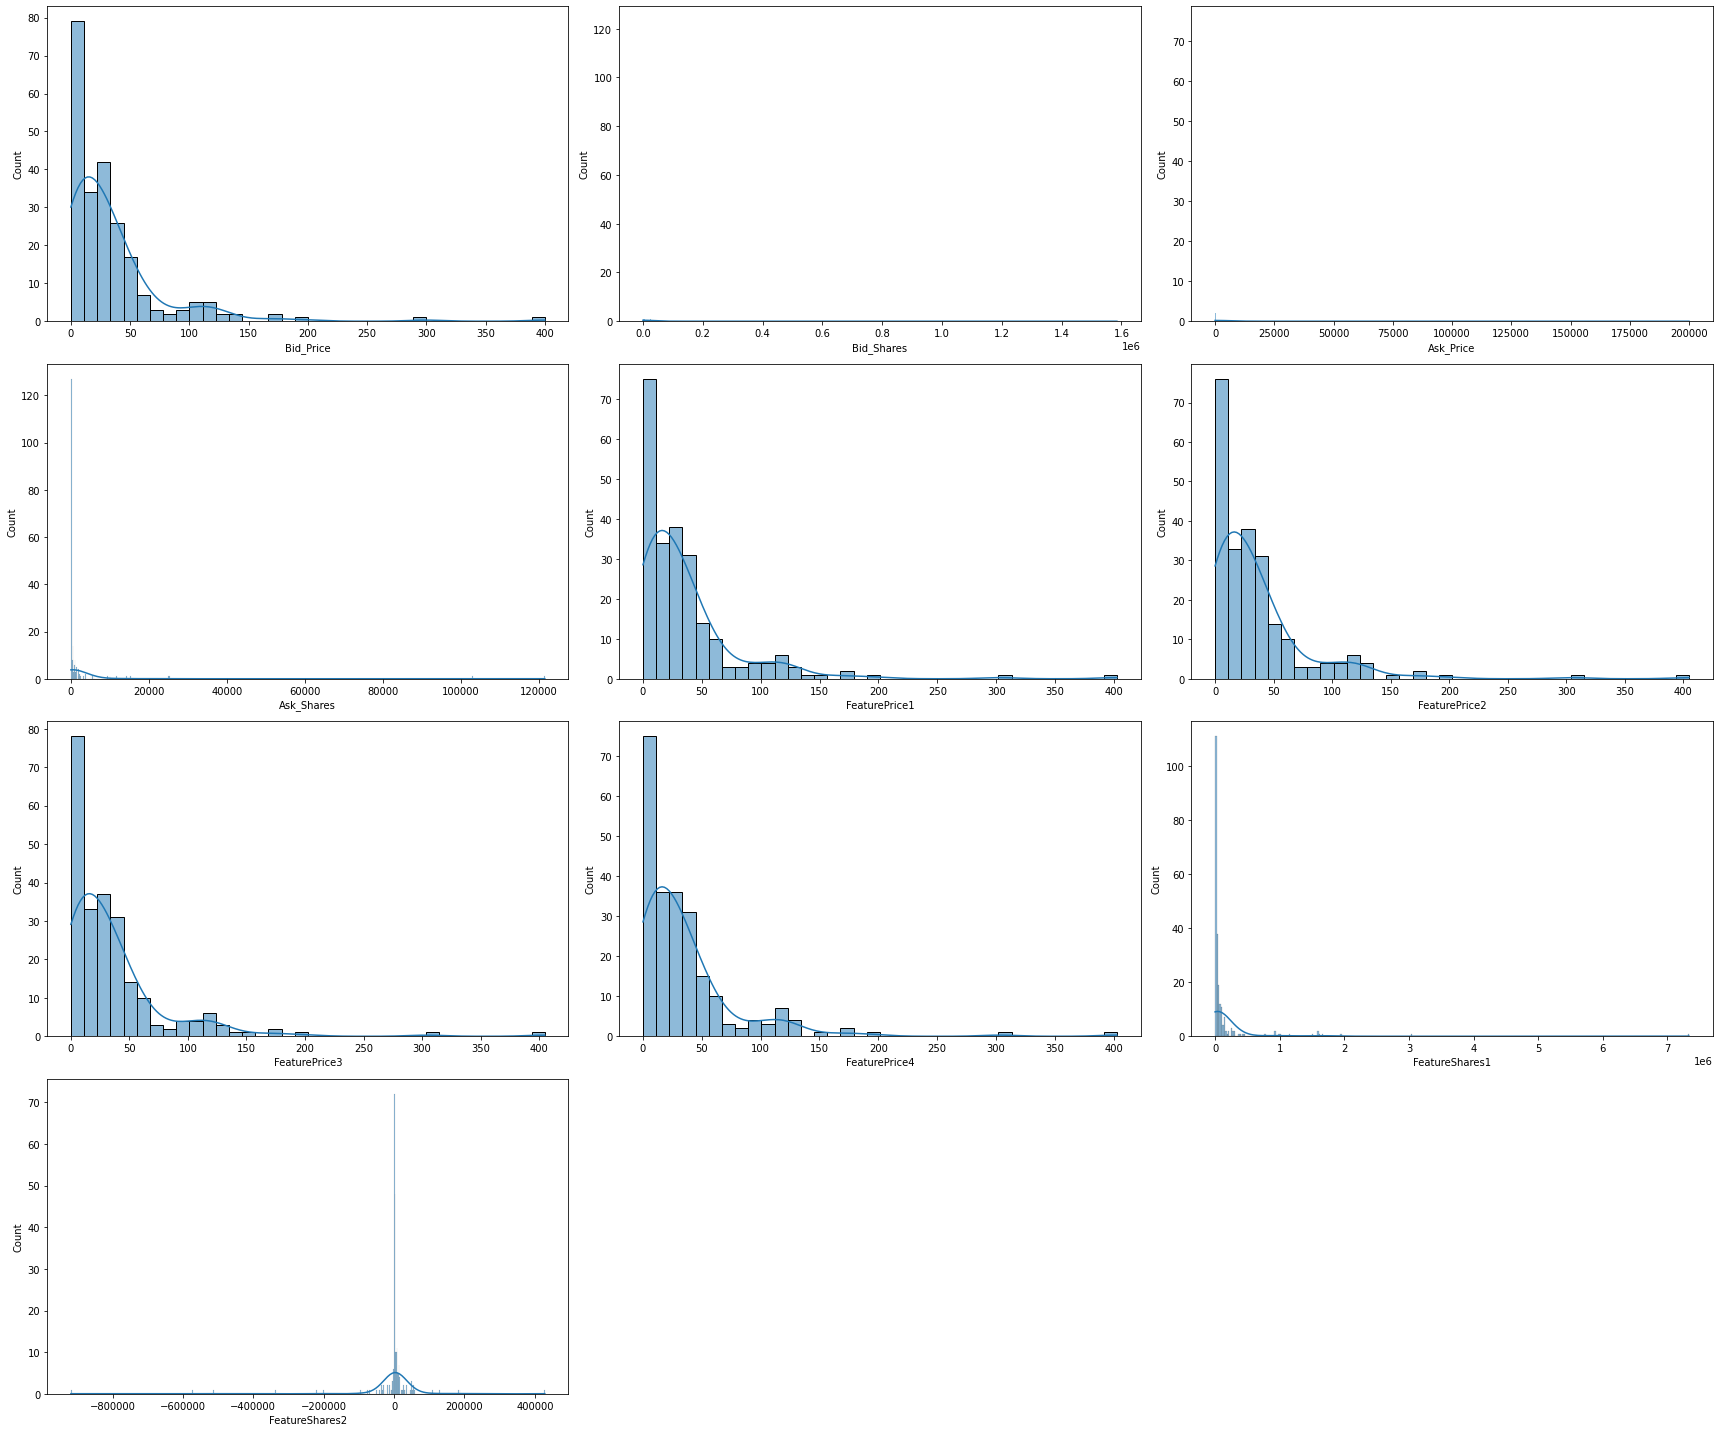

In [60]:
plot_dists(test[test['Date'] == '2016-09-16'].iloc[:, 1:])

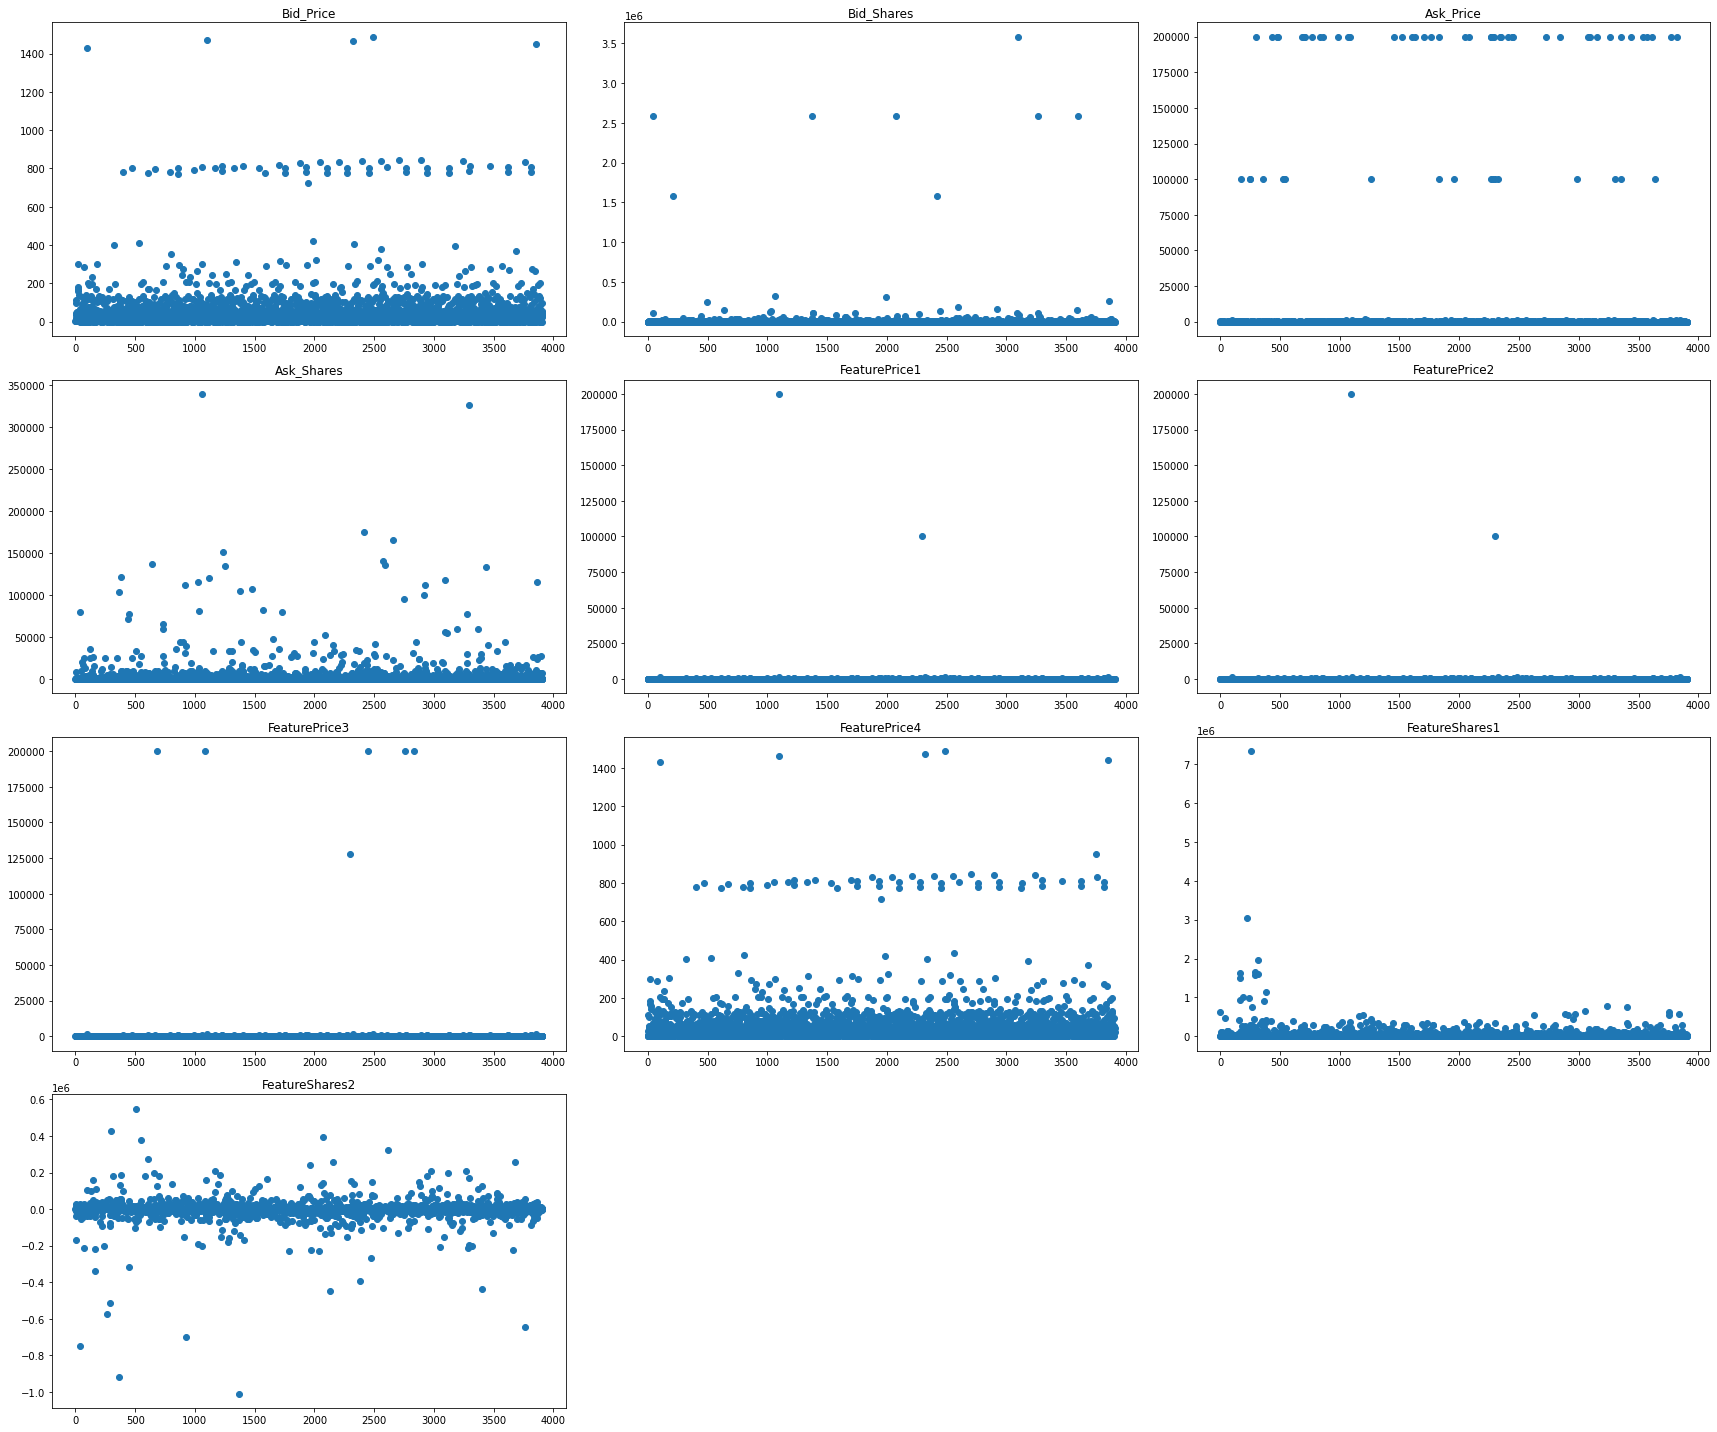

In [61]:
plot_scatters(test.iloc[:, 1:])

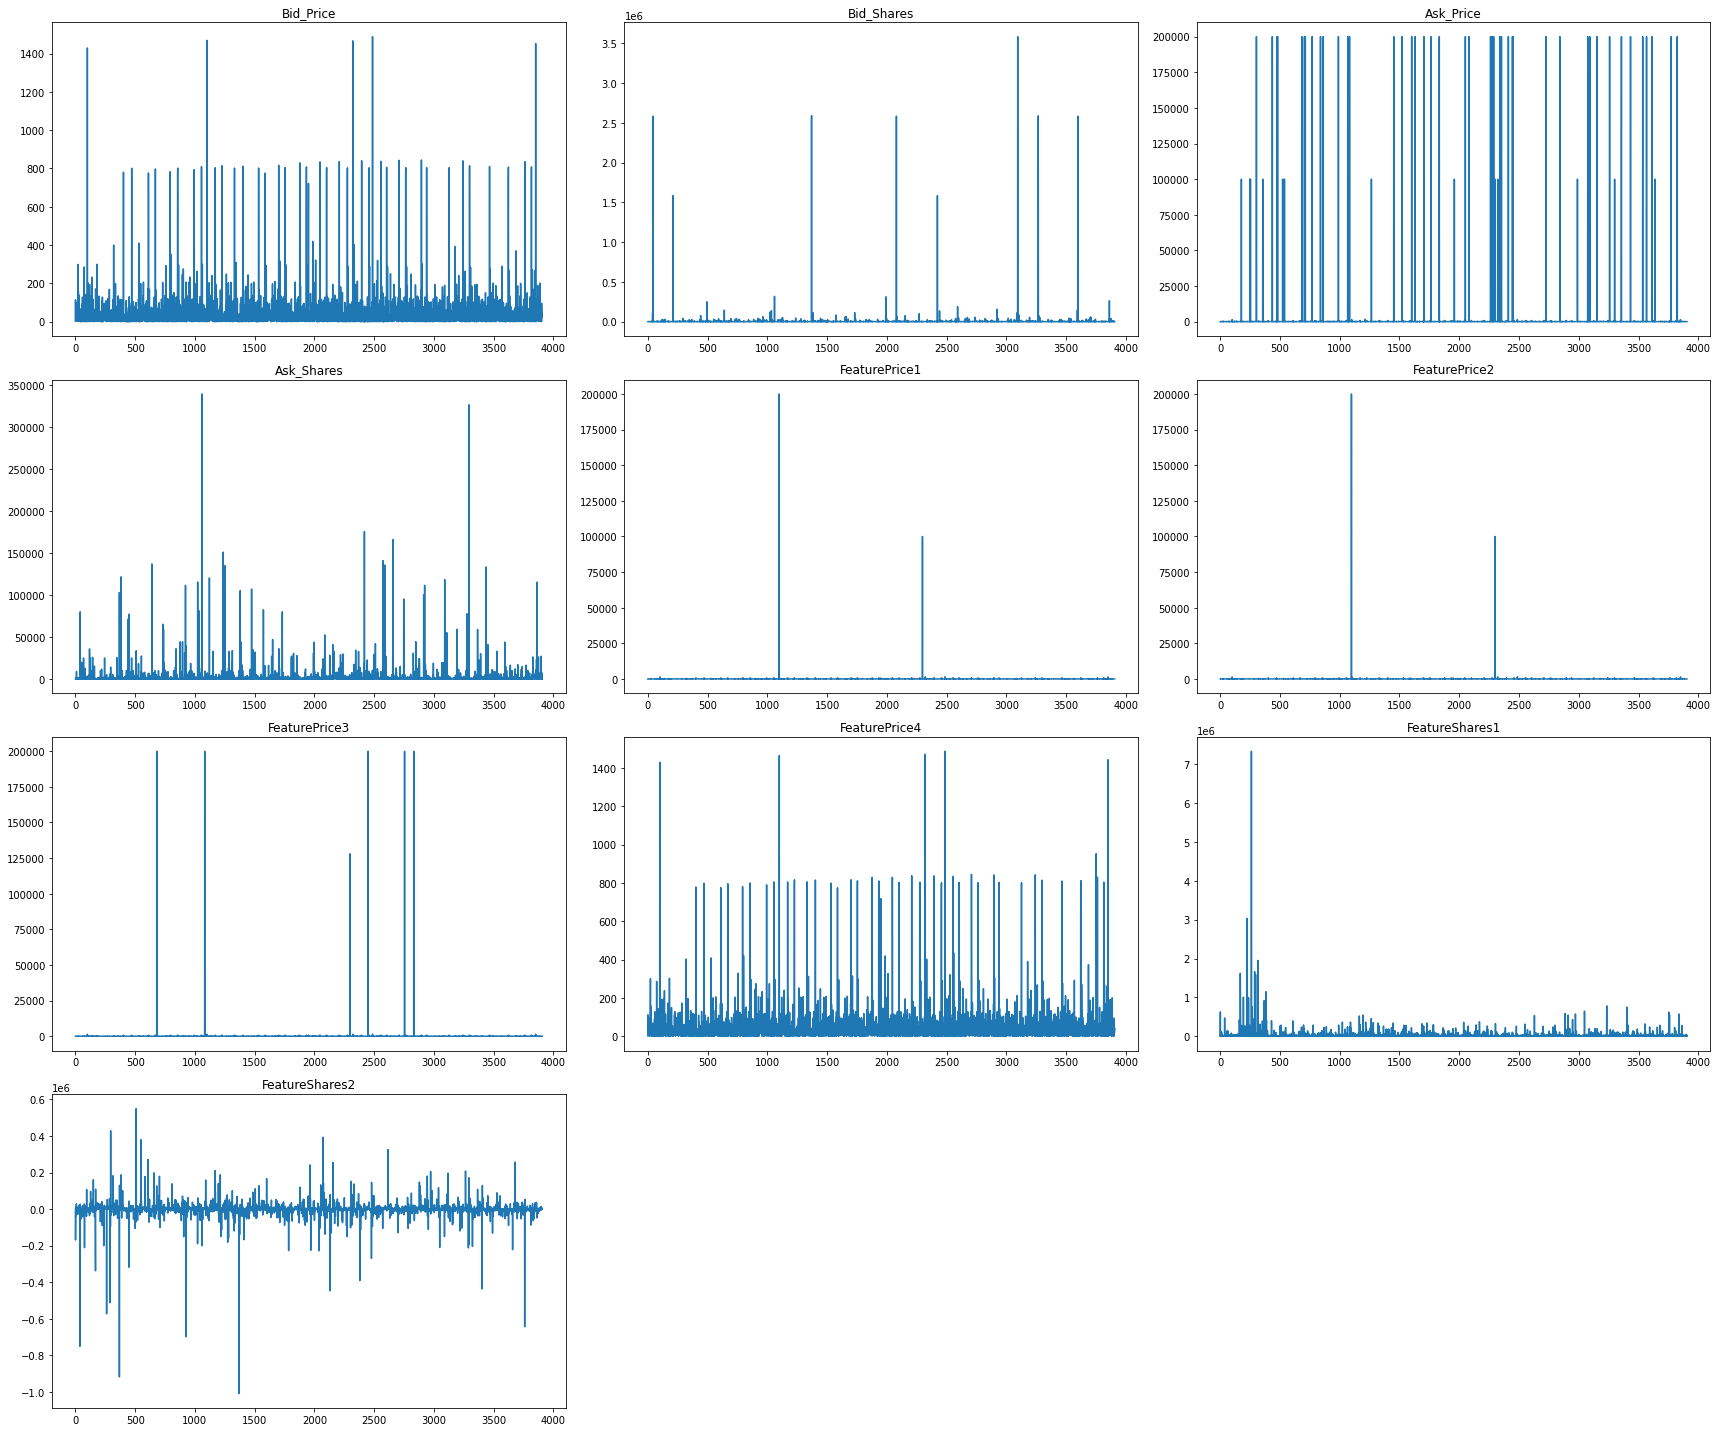

In [62]:
plot_lines(test.iloc[:, 1:])

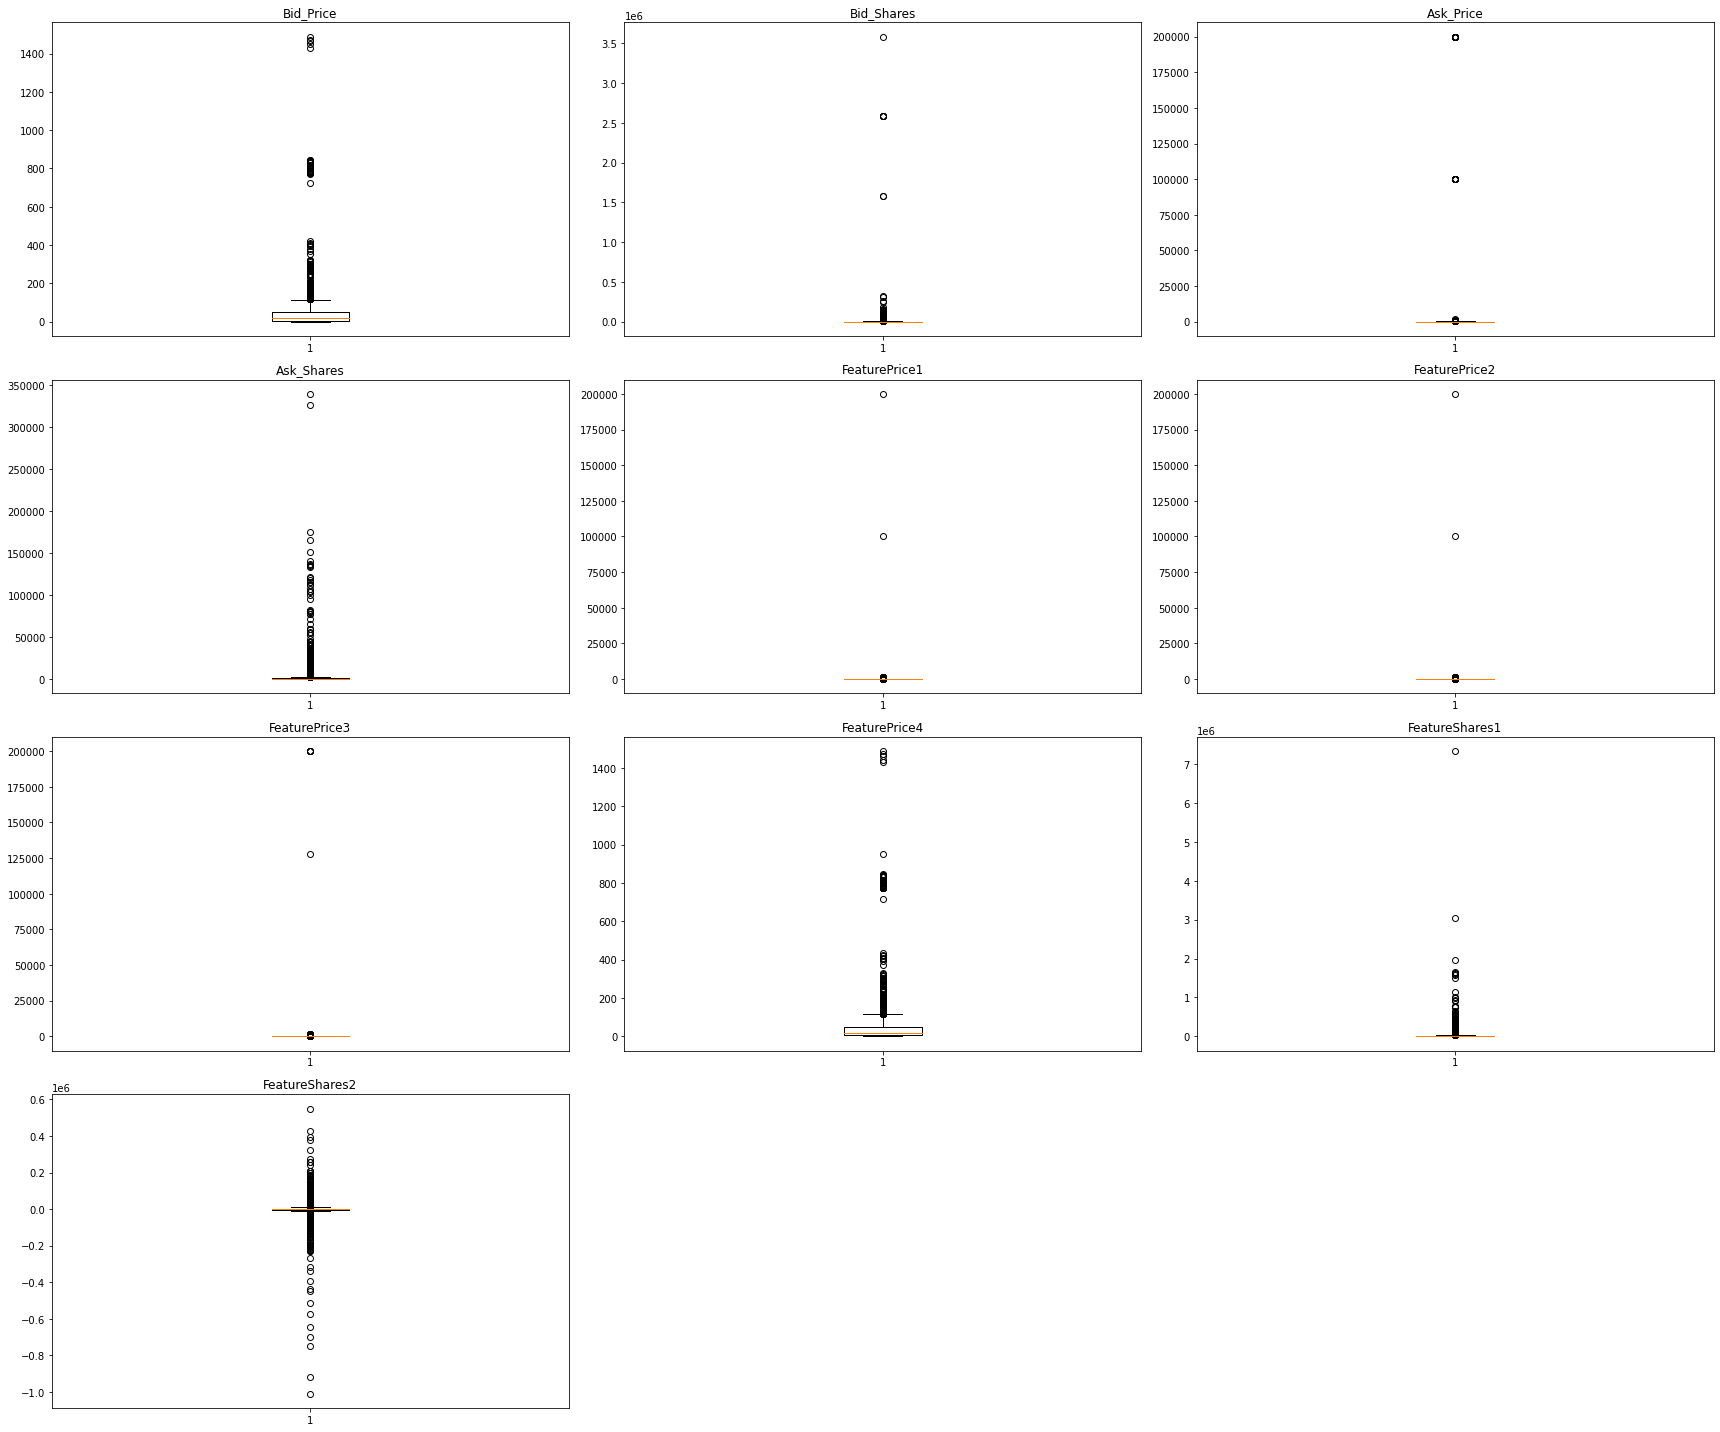

In [63]:
plot_boxes(test.iloc[:, 1:])

In [64]:
test.iloc[:, 1:].skew().sort_values(ascending=False)

FeaturePrice1     50.236082
FeaturePrice2     50.236081
FeatureShares1    29.498028
FeaturePrice3     26.085759
Bid_Shares        23.376796
Ask_Shares        13.469367
Ask_Price          8.386175
Bid_Price          6.860532
FeaturePrice4      6.793434
FeatureShares2    -7.171040
dtype: float64

In [65]:
show_outliers(test, 'FeaturePrice2')

Number of outliers:  2



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
1098,2016-09-22,0.90,100,1.65,100,199999.99,199999.99,0.0,1.590,1537,849
2298,2016-10-03,0.01,400,100000.00,100,100000.00,100000.00,128000.0,34.271,0,2


In [66]:
show_outliers(test, 'FeaturePrice1')

Number of outliers:  2



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
1098,2016-09-22,0.90,100,1.65,100,199999.99,199999.99,0.0,1.590,1537,849
2298,2016-10-03,0.01,400,100000.00,100,100000.00,100000.00,128000.0,34.271,0,2


In [67]:
show_outliers(test, 'FeaturePrice3')

Number of outliers:  6



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
683,2016-09-20,10.00,10000,199999.99,100,12.42,12.42,199999.99,10.230,943,57
1082,2016-09-22,0.01,300,199999.99,100,27.30,27.61,199999.99,27.380,0,420
2298,2016-10-03,0.01,400,100000.00,100,100000.00,100000.00,128000.00,34.271,0,2
2449,2016-10-04,0.01,100,199999.99,100,25.55,26.60,199999.99,25.490,0,300
2754,2016-10-06,15.27,500,15.55,2000,15.55,15.55,199999.99,15.464,0,142
2831,2016-10-06,50.51,400,53.12,400,53.12,53.12,199999.99,52.870,0,688


In [68]:
show_outliers(test, 'FeaturePrice4')

Number of outliers:  64



,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2
100,2016-09-15,1429.00,22,1431.22,6,1431.22,1431.99,1431.99,1429.38,2691,139
320,2016-09-16,400.00,850,402.50,50,402.50,404.83,404.83,402.75,115715,13837
402,2016-09-19,780.00,58,780.70,1000,780.64,780.65,780.65,778.52,29291,952
471,2016-09-19,801.10,1,802.22,55,801.56,800.25,800.18,797.97,13086,-2633
530,2016-09-19,410.00,50,415.00,1,410.00,409.68,409.68,408.63,4145,-937
611,2016-09-20,776.25,10,777.75,120,777.75,778.59,778.60,775.10,20157,11843
669,2016-09-20,797.00,200,798.21,200,798.21,799.79,799.80,795.39,9348,10410
793,2016-09-21,783.00,1,783.20,200,782.83,782.53,782.53,780.22,24598,-2300
801,2016-09-21,350.60,100,500.79,100,420.99,421.21,421.21,421.41,5,44
855,2016-09-21,773.00,303,773.90,83,773.00,772.65,772.65,771.41,11684,-1837


Fine, based on the above analysis, we can assume that the test set has identical characteristics to the training set, so let's assume that all the methods that we applied to the training set are applicable to the test set.

Firstly, we should normalize the initial dataset.

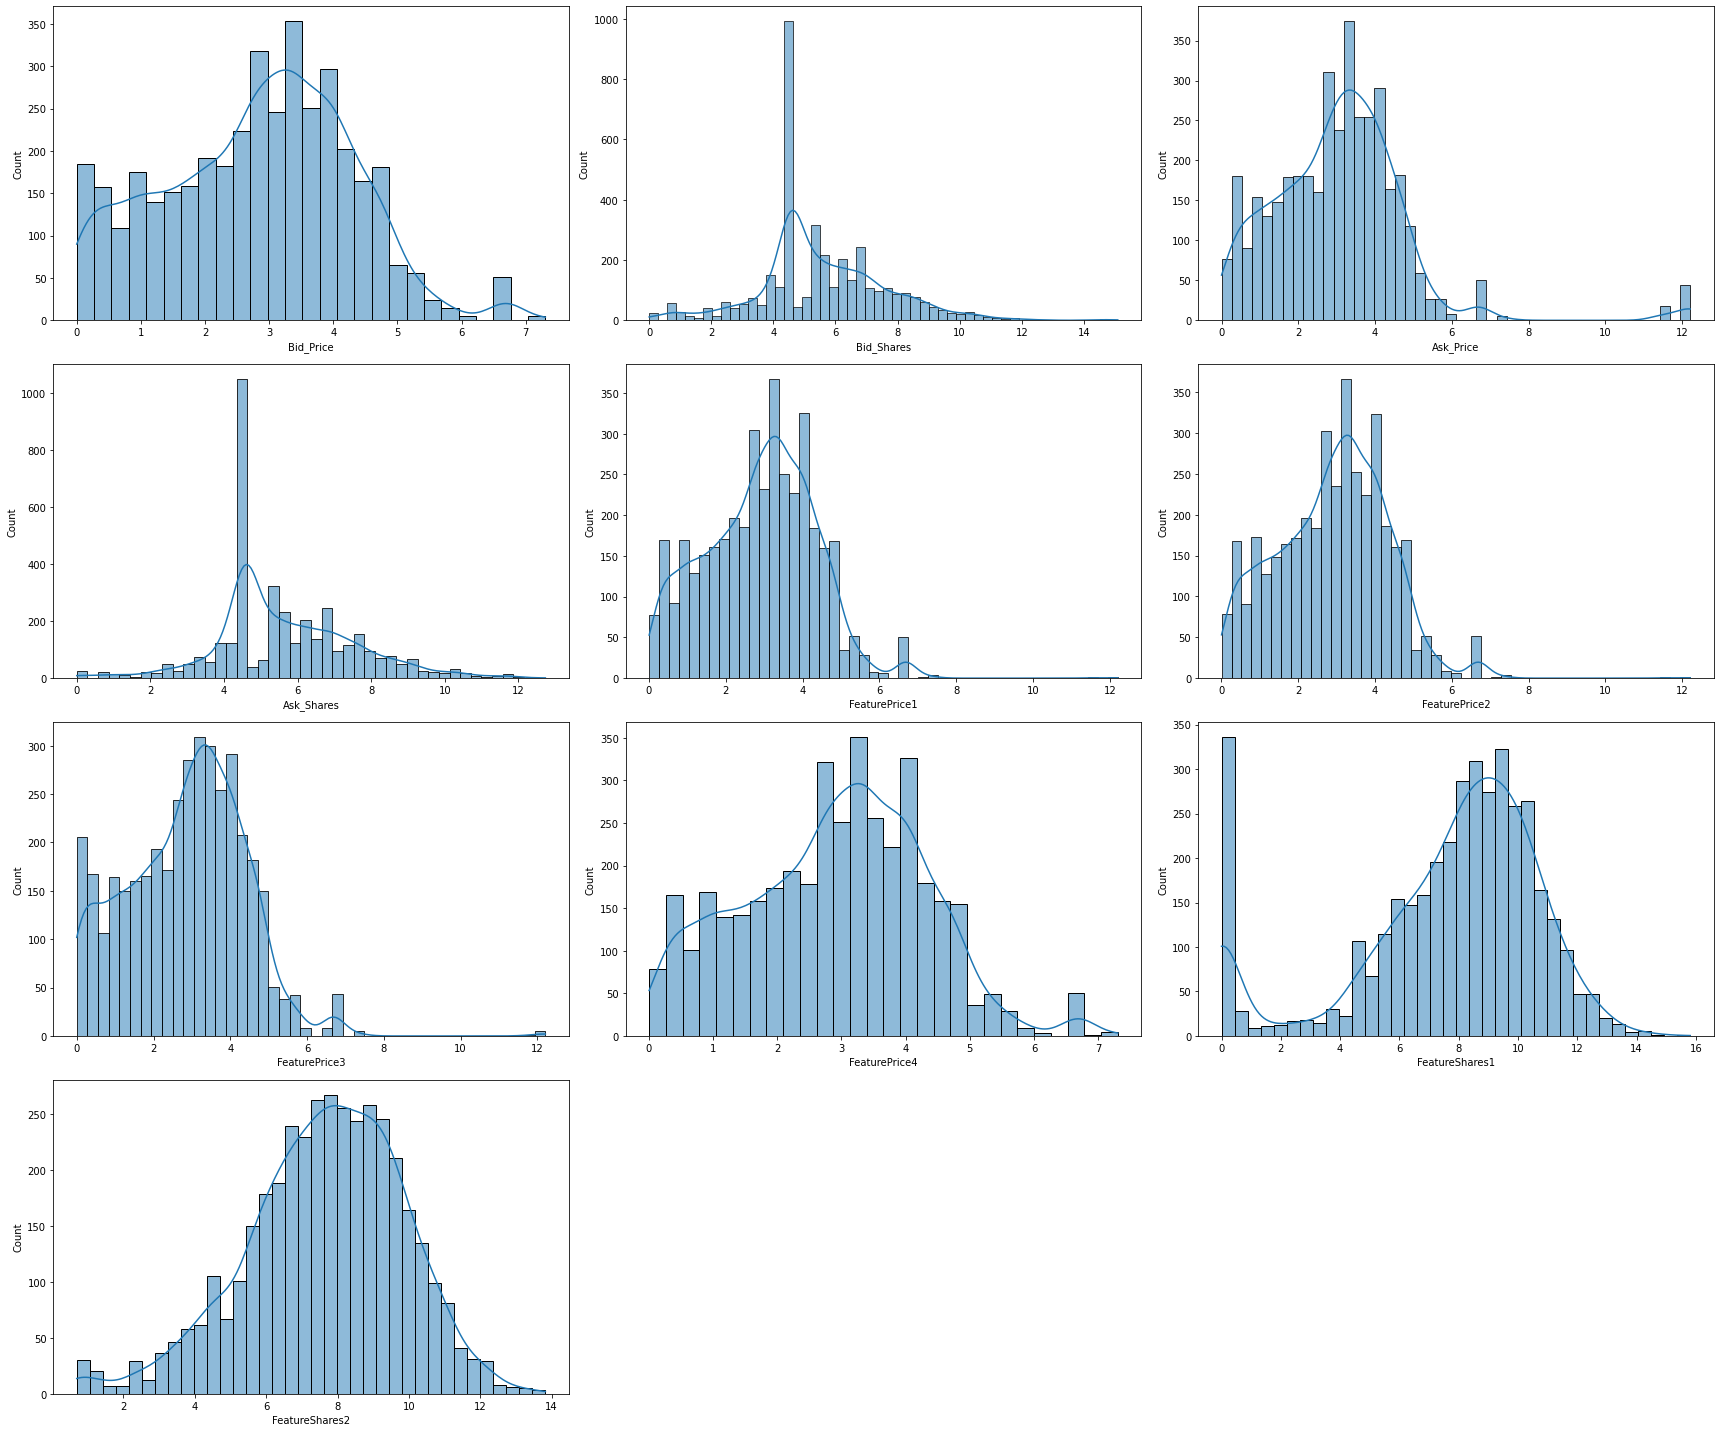

In [69]:
test_normalized = normalize_data(test)
plot_dists(test_normalized.iloc[:, 1:])

Now, we going to fit the model on the training dataset and use it to make predictions on our test dataset.

In [92]:
X, y = data_normalized.iloc[:, 1:-1], data_normalized.iloc[:, -1]
model = ML_models['AdaBoostRegressor'].fit(X, y)
train_score = model.score(X, y)

print('Train Score: ', train_score)

Train Score:  0.9999831377970017


In [93]:
X_test = test_normalized.iloc[:, 1:]
y_pred = model.predict(X_test)

In [94]:
test_pred_normalized = test_normalized.copy(deep=True)
test_pred_normalized['y_pred'] = y_pred
test_pred_normalized

,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,y_pred
0,2016-09-15,1.398717,5.303305,1.728109,4.615121,1.492904,1.492904,0.000000,1.497388,0.000000,2.484907,1.501065
1,2016-09-15,4.742930,4.615121,4.742930,6.398595,4.742930,4.741535,4.741535,4.725350,13.347647,12.036328,4.740783
2,2016-09-15,1.175573,4.615121,1.275363,6.859615,1.175573,1.175573,1.175573,1.175573,7.353082,5.393628,1.184788
3,2016-09-15,1.530395,4.615121,1.534714,5.303305,1.534714,1.539015,1.539015,1.453953,10.448019,9.460866,1.516289
4,2016-09-15,2.022871,4.615121,2.041220,3.951244,2.022871,2.012233,2.012233,1.955860,7.838738,8.995165,2.008219
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,2016-10-14,3.634951,8.828055,3.635215,8.909370,3.635215,3.636533,3.637586,3.608212,10.625392,8.925720,3.637032
3903,2016-10-14,3.990834,4.615121,3.994524,6.216606,3.990834,3.988984,3.988984,3.976311,8.600799,7.963112,3.978800
3904,2016-10-14,3.427190,5.707110,3.456632,4.615121,3.456632,3.456632,3.456632,3.445533,9.758809,6.766192,3.453722
3905,2016-10-14,3.802654,6.908755,3.803992,6.908755,3.803992,3.803992,3.806662,3.792338,5.198497,6.192362,3.804208


Let's compare our results with Bid_Price feature, as it is the closest one.

In [95]:
print('MSE: ', mean_squared_error(test_pred_normalized['Bid_Price'], y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(test_pred_normalized['Bid_Price'], y_pred)))
print('MAE: ', mean_absolute_error(test_pred_normalized['Bid_Price'], y_pred))

MSE:  0.15819138013731787
RMSE:  0.39773279992643035
MAE:  0.0819372974173805


As we made learning on normalized data, now we need to reverse the normalization.

In [96]:
test_pred = test.copy(deep=True)
test_pred['y_pred'] = np.exp(y_pred) - 1
test_pred

,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,y_pred
0,2016-09-15,3.05,200,4.63,100,3.45,3.45,0.00,3.47,0,11,3.486465
1,2016-09-15,113.77,100,113.77,600,113.77,113.61,113.61,111.77,626338,-168775,113.523782
2,2016-09-15,2.24,100,2.58,952,2.24,2.24,2.24,2.24,1560,-219,2.269992
3,2016-09-15,3.62,100,3.64,200,3.64,3.66,3.66,3.28,34475,12846,3.555291
4,2016-09-15,6.56,100,6.70,51,6.56,6.48,6.48,6.07,2536,-8063,6.450034
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,2016-10-14,36.90,6822,36.91,7400,36.91,36.96,37.00,35.90,41166,7522,36.978964
3903,2016-10-14,53.10,100,53.30,500,53.10,53.00,53.00,52.32,5435,-2872,52.452831
3904,2016-10-14,29.79,300,30.71,100,30.71,30.71,30.71,30.36,17305,867,30.617864
3905,2016-10-14,43.82,1000,43.88,1000,43.88,43.88,44.00,43.36,180,488,43.889705


The results with reversed normalization seem not so good.



In [97]:
print('MSE: ', mean_squared_error(test_pred['Bid_Price'], y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(test_pred['Bid_Price'], y_pred)))
print('MAE: ', mean_absolute_error(test_pred['Bid_Price'], y_pred))

MSE:  14127.839623461481
RMSE:  118.86058902538504
MAE:  43.725454559997914


Let's check the best results with the not normalized dataset.

In [103]:
results[~results['Dataset'].str.contains('Norm')].sort_values('MeanSquaredError', ascending=True).head(10)

,ModelType,Model,Dataset,Split,IsScaled,RSquaredTrain,RSquaredTest,MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError
178,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,True,0.999996,0.999908,1.348780,1.161370,0.263201
179,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,False,0.999997,0.999900,1.472702,1.213549,0.250091
106,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,True,1.000000,0.999885,1.682297,1.297034,0.250963
107,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,False,1.000000,0.999868,1.941686,1.393444,0.263345
19,Machine Learning Model,LinearRegression,Data Updated Features Median,0.8,False,0.998302,0.999831,2.487055,1.577040,0.253255
18,Machine Learning Model,LinearRegression,Data Updated Features Median,0.8,True,0.998302,0.999831,2.487055,1.577040,0.253255
67,Machine Learning Model,Ridge,Data Updated Features Median,0.8,False,0.998302,0.999831,2.487055,1.577040,0.253255
43,Machine Learning Model,Lasso,Data Updated Features Median,0.8,False,0.998302,0.999831,2.487239,1.577098,0.252676
66,Machine Learning Model,Ridge,Data Updated Features Median,0.8,True,0.998302,0.999831,2.487427,1.577158,0.252208
91,Machine Learning Model,ElasticNet,Data Updated Features Median,0.8,False,0.998302,0.999831,2.487461,1.577169,0.252131


In [104]:
results[~results['Dataset'].str.contains('Norm')].sort_values(by=['RSquaredTest', 'MeanSquaredError', 'RootMeanSquaredError', 'MeanAbsoluteError', 'RSquaredTrain'], ascending=[False, True, True, True, False])

,ModelType,Model,Dataset,Split,IsScaled,RSquaredTrain,RSquaredTest,MeanSquaredError,RootMeanSquaredError,MeanAbsoluteError
178,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,True,0.999996,0.999908,1.348780,1.161370,0.263201
179,Machine Learning Model,AdaBoostRegressor,Data Updated Features,0.8,False,0.999997,0.999900,1.472702,1.213549,0.250091
106,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,True,1.000000,0.999885,1.682297,1.297034,0.250963
107,Machine Learning Model,DecisionTreeRegressor,Data Updated Features,0.8,False,1.000000,0.999868,1.941686,1.393444,0.263345
65,Machine Learning Model,Ridge,Data Updated Features Median,0.7,False,0.998026,0.999833,2.488919,1.577631,0.243256
...,...,...,...,...,...,...,...,...,...,...
90,Machine Learning Model,ElasticNet,Data Updated Features Median,0.8,True,0.554235,0.554988,6532.162409,80.821794,34.913472
88,Machine Learning Model,ElasticNet,Data Updated Features Median,0.7,True,0.554020,0.554980,6633.954795,81.449093,35.327623
198,Deep Learning Model,LSTM,Data Initial,0.8,False,0.308756,0.301868,10247.611533,101.230487,16.127129
200,Deep Learning Model,LSTM,Data Updated Features,0.8,False,0.308282,0.301109,10258.748621,101.285481,15.912685


Ok, let's try AdaBoostRegressor fitted on scaled Data Updated Features dataset.

In [112]:
X_scaler, y_scaler = StandardScaler(), StandardScaler()

X, y = data_updated_features.iloc[:, 1:-1], data_updated_features.iloc[:, -1]
y_reshaped = y.to_numpy().reshape(-1, 1)
X, y = X_scaler.fit_transform(X), y_scaler.fit_transform(y_reshaped)


model = ML_models['AdaBoostRegressor'].fit(X, y)
train_score = model.score(X, y)

print('Train Score: ', train_score)

Train Score:  0.9999957134051242


In [113]:
test_updated_features = test.copy(deep=True)

columns_to_replace_outliers = ['FeaturePrice1', 'FeaturePrice2', 'FeaturePrice3', 'FeaturePrice4']
columns_to_remove = ['Bid_Shares', 'Ask_Price', 'Ask_Shares', 'FeatureShares1', 'FeatureShares2']

test_updated_features[columns_to_replace_outliers] = test_updated_features[columns_to_replace_outliers].apply(replace_outliers)
test_updated_features.drop(labels=columns_to_remove, axis=1, inplace=True)

test_updated_features['Bid_Price'] = test_updated_features['Bid_Price'].where(test_updated_features['Bid_Price'] != 0, test_updated_features[columns_to_replace_outliers].median(axis=1))

assert len(test_updated_features[test_updated_features['Bid_Price'] == 0]) == 0

In [116]:
X_test = test_updated_features.iloc[:, 1:]
X_test = X_scaler.transform(X_test)

y_pred = model.predict(X_test)
y_pred_reshaped = y_pred.reshape(-1, 1)
y_pred = y_scaler.inverse_transform(y_pred_reshaped)

In [121]:
test_pred = test.copy(deep=True)
test_pred['TargetPrice_pred'] = np.round(y_pred, 2)
test_pred

,Date,Bid_Price,Bid_Shares,Ask_Price,Ask_Shares,FeaturePrice1,FeaturePrice2,FeaturePrice3,FeaturePrice4,FeatureShares1,FeatureShares2,TargetPrice_pred
0,2016-09-15,3.05,200,4.63,100,3.45,3.45,0.00,3.47,0,11,3.56
1,2016-09-15,113.77,100,113.77,600,113.77,113.61,113.61,111.77,626338,-168775,113.53
2,2016-09-15,2.24,100,2.58,952,2.24,2.24,2.24,2.24,1560,-219,2.26
3,2016-09-15,3.62,100,3.64,200,3.64,3.66,3.66,3.28,34475,12846,3.71
4,2016-09-15,6.56,100,6.70,51,6.56,6.48,6.48,6.07,2536,-8063,6.41
...,...,...,...,...,...,...,...,...,...,...,...,...
3902,2016-10-14,36.90,6822,36.91,7400,36.91,36.96,37.00,35.90,41166,7522,37.11
3903,2016-10-14,53.10,100,53.30,500,53.10,53.00,53.00,52.32,5435,-2872,52.28
3904,2016-10-14,29.79,300,30.71,100,30.71,30.71,30.71,30.36,17305,867,30.55
3905,2016-10-14,43.82,1000,43.88,1000,43.88,43.88,44.00,43.36,180,488,43.98


Looks better.

In [122]:
print('MSE: ', mean_squared_error(test_pred['Bid_Price'], y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(test_pred['Bid_Price'], y_pred)))
print('MAE: ', mean_absolute_error(test_pred['Bid_Price'], y_pred))

MSE:  209.0927601950011
RMSE:  14.460040117337195
MAE:  1.693171851014592


Saving Test with predictions of TargetPrice variable.

In [124]:
test_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/Others/Test_pred.csv', index=False)

# Conclusions

Summing up, we can say that we have carried out a large analysis of the existing dataset and, as a result, have achieved a high-quality model work.

All regression models showed quite good results, especially AdaBoostRegressor, which we eventually used to predict the test dataset.

Neural networks did not perform well, but in some cases, they were also not bad in their predictions. Recurrent neural networks were used for an experimental purpose, it was initially clear that there could probably be no consistent relationship between variables.

The Prophet library was also tested for time series forecasting, but since we have snapshots for various stocks, there can be no dependence on the sequence of TargetPrice values. The result of the model built with the Prophet was terrible, and therefore is not included in this notebook.

We concatenated the results obtained with the test dataset and saved it as a CSV file.